In [250]:
import numpy as np
import pandas as pd
import torch
import yaml
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import KernelPCA

In [825]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.ensemble import IsolationForest

from xgboost import plot_importance

In [3]:
#import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [4]:
from sklearn.metrics import f1_score
#F1 = f1_score(y_true, y_pred, average='micro')

In [5]:
## SPLIT FUNCTIONS FOR CV ##

def split_df(df, n) :
    '''
    df: dataframe to shuffle and split
    n: amount of to be splitted pieces
    splits: list of dataframes (splits)
    '''
    # defining list with optimal cutting points
    split_points = list(map( lambda x: int(x*len(df)/n), (list(range(1,n)))))  
    # shuffling the df, then splitting it from split_points
    splits = list(np.split(df.sample(frac=1), split_points))
    return splits

def make_train_and_test(splits, index) :
    '''
    Take splits from splitDf, and return into test set (splits[index])
    and training set (the rest)
    '''
    
    # index is zero based, so range 0-9 for 10 fold split
    test = splits[index]

    left_lst = splits[:index]
    right_lst = splits[index+1:]

    train = pd.concat(left_lst+right_lst)
    return train, test

In [6]:
X_train_df = pd.read_csv('raw/X_train.csv')
y_train_df = pd.read_csv('raw/y_train.csv')
X_test_df = pd.read_csv('raw/X_test.csv')
sample_df = pd.read_csv('raw/sample.csv')

#train_data_df = pd.concat([X_train_df, y_train_df.drop(['id'], axis=1)], axis=1)
#columns = np.array(train_data_df.columns)
#train_data = train_data_df.to_numpy()

/opt/anaconda3/envs/working/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17979) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# -----------------

In [7]:
y_train_df['y'].values[:20]

array([0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1])

In [8]:
visual = np.array(X_train_df.drop(['id'], axis=1).fillna(value=0).iloc[4])
visual2 = np.array(X_train_df.drop(['id'], axis=1).fillna(value=0).iloc[1])
visual3 = np.array(X_train_df.drop(['id'], axis=1).fillna(value=0).iloc[10])

In [9]:
x = np.linspace(0,1000,len(visual))

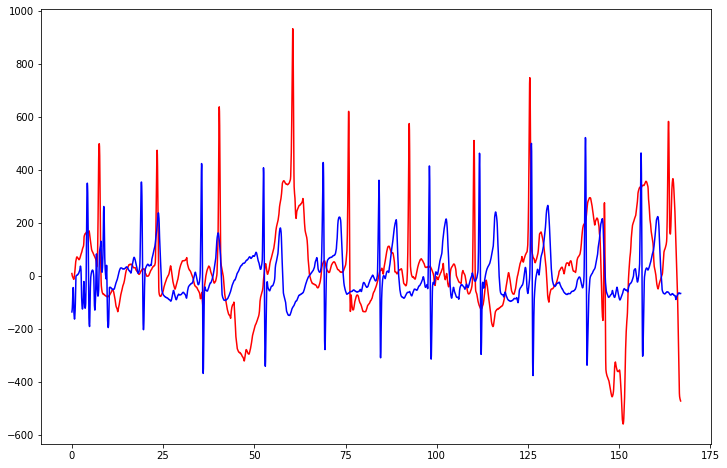

In [10]:
plt.figure(figsize=(12,8))
plt.plot(x[:3000], visual[:3000], '-r')
plt.plot(x[:3000], visual2[:3000], '-b')
#plt.plot(x[:3000], visual3[:3000], '-g')

# TIMESERIES ANALYSIS

In [11]:
import biosppy.signals.ecg as ecg
import neurokit as nk
import neurokit2 as nk2
import math

In [12]:
X_train_df.values.shape

(5117, 17980)

In [1626]:
y_train_df

,id,y
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
5112,5112,3
5113,5113,2
5114,5114,0
5115,5115,0


In [1627]:
considered_patient = X_train_df.values[3]

In [1628]:
considered_patient = np.array([value for value in considered_patient if not math.isnan(value)])

In [1629]:
ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(considered_patient, sampling_rate=300, show=False)
templates_, rpeaks_ = ecg.extract_heartbeats(filtered, rpeaks = rpeaks, sampling_rate=300)


In [1630]:
rpeaks

array([ 306,  560,  828, 1076, 1369, 1651, 1939, 2178, 2498, 2776, 3053,
       3314, 3599, 3870, 4139, 4384, 4668, 4929, 5192, 5451, 5711, 5953,
       6232, 6488, 6745, 6993, 7265, 7525, 7786, 8032, 8313])

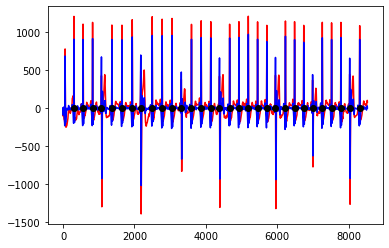

In [1631]:
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient)), considered_patient, '-r')
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient)), filtered, '-b')
plt.plot(rpeaks, np.zeros(len(rpeaks)), 'ok')

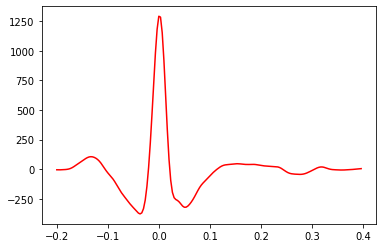

In [18]:
plt.plot(templates_ts,templates[1],'-r')

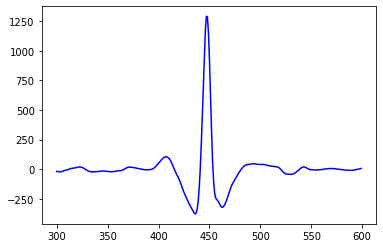

In [62]:
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient))[300:600], filtered[300:600], '-b')

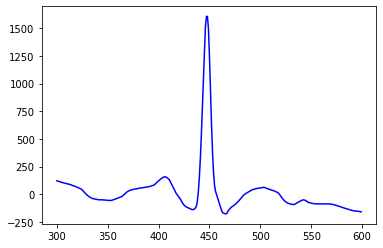

In [63]:
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient))[300:600], considered_patient[300:600], '-b')

In [64]:
preprocessed = nk.ecg_preprocess(considered_patient, sampling_rate=300)

/opt/anaconda3/envs/working/lib/python3.8/site-packages/neurokit/bio/bio_ecg_preprocessing.py:178: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  heartbeats.index = pd.date_range(pd.datetime.today(), periods=len(heartbeats), freq=str(int(1000/sampling_rate)) + "L")


In [74]:
preprocessed = np.array(preprocessed['df']['ECG_Filtered'])

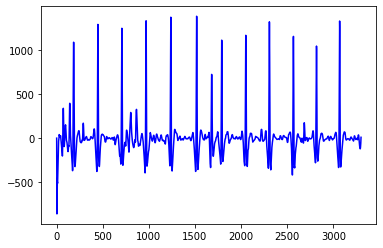

In [75]:
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient)), preprocessed, '-b')

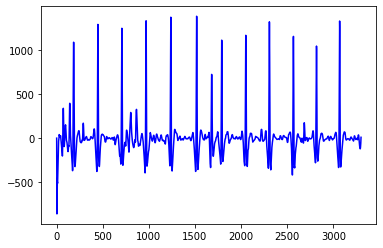

In [76]:
plt.plot(np.linspace(0,len(considered_patient)-1,len(considered_patient)), filtered, '-b')

In [187]:
import sklearn_models.extract_features

In [189]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg

#import nkcopy
#import frequency_analysis


def extract_features(ecg_df, numberOfFeatures = 17):
    '''
    input shape: (N,P) where N amount of samples, P number of timesteps (should be 2220)
    '''

    features_names_timehvr = ['sdNN', 'meanNN', 'CVSD', 'cvNN', 'RMSSD', 'medianNN',
                              'madNN', 'mcvNN', 'pNN50', 'pNN20']

    features_names_freqhvr = ['ULF', 'VLF', 'LF', 'HF', 'VHF', 'Total', 'extra1', 'extra2',
                              'extra3', 'extra4', 'extra5', 'corr_max', 'corr_min', 'corr1', 'corr2', 'corr3']

    number_of_samples = ecg_df.values.shape[0]

    extracted_features = np.empty([number_of_samples, numberOfFeatures])

    for i in range(number_of_samples):
        if i % 1 == 0:
            print('Iteration {i} done'.format(i=i))
        features = np.empty([1, 0])

        currentPatient = ecg_df.iloc[i].dropna().values

        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(currentPatient,
                                                                                           sampling_rate=300,
                                                                                           show=False)
        templates, rpeaks_ = ecg.extract_heartbeats(filtered, rpeaks=rpeaks, sampling_rate=300)


        # add mean, max, min, median, std of r amplitudes
        R_Peaks = filtered[rpeaks]

        mean_rvalues = np.mean(R_Peaks)
        min_rvalues = np.min(R_Peaks)
        max_rvalues = np.max(R_Peaks)
        std_rvalues = np.std(R_Peaks)
        median_rvalues = np.median(R_Peaks)

        means_of_r = np.empty([1, 5])
        means_of_r[0, :] = [mean_rvalues, min_rvalues, max_rvalues, std_rvalues, median_rvalues]
        features = np.append(features, means_of_r, axis=1)


        # add power (whatever this is)
        power = np.sum(np.square(filtered)) / filtered.shape[0]
        features = np.append(features, power.reshape(1, -1), axis=1)


        # add the mean, mean-max, mean-min, mean-std, mean-median of cardiac cycles
        Cardiadic_Cycles = pd.DataFrame(templates)

        mean = Cardiadic_Cycles.mean(axis=0).mean()
        mean_max = Cardiadic_Cycles.max(axis=0).mean()
        mean_min = Cardiadic_Cycles.min(axis=0).mean()
        mean_median = Cardiadic_Cycles.median(axis=0).mean()
        mean_std = Cardiadic_Cycles.std(axis=0).mean()

        max_min = Cardiadic_Cycles.min(axis=0).max()
        min_min = Cardiadic_Cycles.min(axis=0).min()

        max_max = Cardiadic_Cycles.max(axis=0).max()
        min_max = Cardiadic_Cycles.max(axis=0).min()

        max_std = Cardiadic_Cycles.std(axis=0).max()
        min_std = Cardiadic_Cycles.std(axis=0).min()

        to_add = np.empty([1, 11])
        to_add[0, :] = [mean, mean_max, mean_min, mean_median, mean_std, max_min, min_min, max_max, min_max, max_std,
                        min_std]

        features = np.append(features, to_add, axis=1)

        extracted_features[i, :] = features

    return extracted_features

In [211]:
considered_patient = X_train_df.values[1]
considered_patient = np.array([value for value in considered_patient if not math.isnan(value)])

ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(considered_patient[:2520], sampling_rate=300, show=False)
templates, rpeaks_ = ecg.extract_heartbeats(filtered, rpeaks = rpeaks, sampling_rate=300)

In [212]:
templates.shape

(9, 180)

In [213]:
considered_patient2 = X_train_df.values[2]
considered_patient2 = np.array([value for value in considered_patient2 if not math.isnan(value)])

ts2, filtered2, rpeaks2, templates_ts2, templates2, heart_rate_ts2, heart_rate2 = ecg.ecg(considered_patient2[:2520], sampling_rate=300, show=False)
templates2, rpeaks_2 = ecg.extract_heartbeats(filtered2, rpeaks = rpeaks2, sampling_rate=300)

In [214]:
templates2.shape

(11, 180)

In [215]:
X_train_df.values.shape

(5117, 17980)

In [217]:
X_train_df.iloc[5116].dropna().values

array([5116, 24, 30, ..., -16.0, -14.0, '\\n'], dtype=object)

In [96]:
currentPatient = X_train_df.drop('id', axis=1).iloc[10].dropna().values

In [97]:
currentPatient

array([-71, -72, -73, ..., -96.0, -96.0, -96.0], dtype=object)

In [98]:
ts3, filtered3, rpeaks3, templates_ts3, templates3, heart_rate_ts3, heart_rate3 = ecg.ecg(currentPatient, sampling_rate=300, show=False)

In [99]:
rpeaks3

array([ 176,  313,  482,  593,  746,  866,  984, 1114, 1251, 1386, 1507,
       1612, 1712, 1872, 2071, 2199, 2311, 2435, 2544, 2691, 2817, 2945,
       3066, 3177, 3320, 3434, 3548, 3652, 3755, 3862, 3965, 4096, 4207,
       4317, 4435, 4552, 4679, 4810, 4920, 5024, 5135, 5238, 5345, 5455,
       5565, 5679, 5792, 5908, 6008, 6119, 6227, 6342, 6463, 6580, 6684,
       6807, 6920, 7028, 7150, 7272, 7377, 7482, 7601, 7758, 7887, 8007,
       8114])

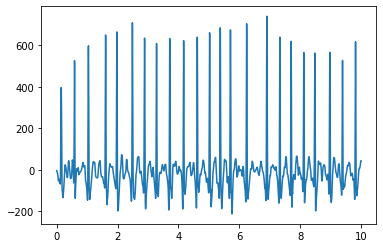

In [111]:
plt.plot(ts3[:3000], filtered3[:3000])

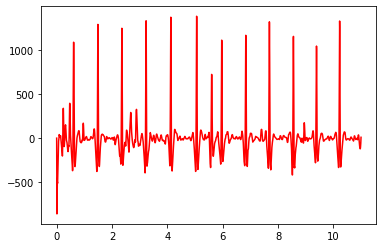

In [108]:
plt.plot(ts, filtered, 'r')

In [100]:
hvr_time_features = nk.ecg_hrv(rpeaks=rpeaks3, sampling_rate=300, hrv_features='time')

NeuroKit Warning: ecg_hrv(): Not enough normal R peaks to compute HRV :/


In [101]:
hvr_time_features['sdNN']

KeyError: 'sdNN'

In [103]:
hvr_time_features

{'n_Artifacts': 0.9848484848484849,
 'RR_Intervals': 13    663.333333
 dtype: float64}

In [19]:
sample = X_train_df.drop('id', axis=1).iloc[:30,:]

In [20]:
sample

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
0,-863,-860,-857,-854,-851,-849,-846,-843,-838,-831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-137,-132,-123,-107,-79,-59,-45,-47,-70,-107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-727,-736,-748,-784,-831,-874,-917,-967,-1029,-1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-103,-98,-92,-87,-81,-77,-71,-65,-61,-59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2,-1,-3,-5,-7,-10,-12,-14,-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,85,78,70,58,39,19,-7,-39,-63,-81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,7,6,6,5,5,5,5,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10,6,2,0,-3,-6,-9,-12,-15,-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1279,1306,1336,1369,1396,1414,1416,1401,1361,1310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-52,-50,-48,-47,-45,-42,-40,-39,-38,-37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
import time

In [22]:
sample.shape

(30, 17979)

In [23]:
start = time.time()
sample.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)
end = time.time()
print(end - start)

3.4038379192352295


In [287]:
start = time.time()
for i in range(len(sample)):
    #if i % 500 == 0:
    #    print('Iteration {i} done'.format(i=i))

    currentPatient = sample.iloc[i].dropna().values

    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(currentPatient,
                                                                                        sampling_rate=300,
                                                                                        show=False)
end = time.time()
print(end - start)

37.45198202133179


In [632]:
values = sample_long.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)

In [633]:
values

0     ([0.0, 0.003332323538321721, 0.006664647076643...
1     ([0.0, 0.0033329488658208383, 0.00666589773164...
2     ([0.0, 0.0033329363188820075, 0.00666587263776...
3     ([0.0, 0.0033329425098682923, 0.00666588501973...
4     ([0.0, 0.0033323885109599392, 0.00666477702191...
                            ...                        
95    ([0.0, 0.0033331400966183575, 0.00666628019323...
96    ([0.0, 0.003332953249714937, 0.006665906499429...
97    ([0.0, 0.0033324636924949996, 0.00666492738498...
98    ([0.0, 0.003332929537653947, 0.006665859075307...
99    ([0.0, 0.0033329441525588636, 0.00666588830511...
Length: 100, dtype: object

In [635]:
features_df

,rpeaks,filtered,templates
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258826, -42.65215944435593, -48.9...","[[-149.84617565092168, -142.86810193402488, -1..."
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328623, -8.184503629133395, -2.69...","[[-64.60771453704189, -39.397723572257156, -9...."
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079727, -12.78226779976711, -1.2...","[[5.68695756150389, -6.140703221431294, -14.90..."
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.33878907945144, 2.3249872820251203, 8.6989...","[[-14.899667069219475, -13.914825480304781, -1..."
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933556, -5.365099622647968, -10....","[[19.907135756915846, 20.620762841806073, 20.9..."
...,...,...,...
95,"[77, 325, 584, 848, 1108, 1370, 1634, 1903, 21...","[2.021959959356016, 0.6737551574082502, -0.135...","[[23.9164424144189, 20.17026568890784, 15.8602..."
96,"[278, 517, 758, 990, 1227, 1469, 1714, 1951, 2...","[1.9377116277161741, 1.0551692414110576, 0.039...","[[4.330284935304363, 3.884276985785814, 3.1140..."
97,"[212, 485, 761, 1030, 1303, 1576, 1848, 2119, ...","[0.8424833163983384, -0.8044977599846999, -2.2...","[[6.338839689971541, 13.939474678556401, 18.83..."
98,"[123, 383, 650, 913, 1172, 1431, 1689, 1949, 2...","[-0.8424833163983391, 0.5983663855319343, 1.95...","[[10.349229247974694, 13.037636464900984, 16.3..."


In [634]:
features_df = pd.DataFrame({'rpeaks':values.apply(lambda x: x['rpeaks']), 
                           'filtered':values.apply(lambda x: x['filtered']),
                           'templates':values.apply(lambda x: x['templates'])})

In [416]:
features_df['R_peaks'] = features_df.apply(lambda x: x['filtered'][x['rpeaks']],axis=1)

In [417]:
features_df['mean_rvalues'] = features_df.apply(lambda x: np.mean(x['R_peaks']), axis=1)
features_df['min_rvalues'] = features_df.apply(lambda x: np.min(x['R_peaks']), axis=1)
features_df['max_rvalues'] = features_df.apply(lambda x: np.max(x['R_peaks']), axis=1)
features_df['std_rvalues'] = features_df.apply(lambda x: np.std(x['R_peaks']), axis=1)
features_df['median_rvalues'] = features_df.apply(lambda x: np.median(x['R_peaks']), axis=1)

In [418]:
features_df['power'] = features_df['filtered'].apply(lambda x: np.sum(np.square(x)) / x.shape[0])

In [419]:
#features_df['Cardiadic_Cycles'] = features_df['templates'].apply(lambda x: x)

features_df['mean'] = features_df['templates'].apply(lambda x: np.mean(np.mean(x, axis=0)))
features_df['mean_max'] = features_df['templates'].apply(lambda x: np.mean(np.max(x, axis=0)))
features_df['mean_min'] = features_df['templates'].apply(lambda x: np.mean(np.min(x, axis=0)))
features_df['mean_median'] = features_df['templates'].apply(lambda x: np.mean(np.median(x, axis=0)))
features_df['mean_std'] = features_df['templates'].apply(lambda x: np.mean(np.std(x.astype(np.float), axis=0)))

features_df['max_min'] = features_df['templates'].apply(lambda x: np.max(np.min(x, axis=0)))
features_df['min_min'] = features_df['templates'].apply(lambda x: np.min(np.min(x, axis=0)))

features_df['max_max'] = features_df['templates'].apply(lambda x: np.max(np.max(x, axis=0)))
features_df['min_max'] = features_df['templates'].apply(lambda x: np.min(np.max(x, axis=0)))

features_df['min_std'] = features_df['templates'].apply(lambda x: np.min(np.std(x.astype(np.float), axis=0)))
features_df['max_std'] = features_df['templates'].apply(lambda x: np.max(np.std(x.astype(np.float), axis=0)))

In [420]:
import numpy as np
import pandas as pd

from scipy import stats

def ecg_hrv(rpeaks=None, rri=None, sampling_rate=1000, hrv_features=["time", "frequency", "nonlinear"]):

    # Check arguments: exactly one of rpeaks or rri has to be given as input
    if rpeaks is None and rri is None:
        raise ValueError("Either rpeaks or RRIs needs to be given.")

    if rpeaks is not None and rri is not None:
        raise ValueError("Either rpeaks or RRIs should be given but not both.")

    # Initialize empty dict
    hrv = {}

    # Preprocessing
    # ==================
    # Extract RR intervals (RRis)
    if rpeaks is not None:
        # Rpeaks is given, RRis need to be computed
        RRis = np.diff(rpeaks)
    else:
        # Case where RRis are already given:
        RRis = rri


    # Basic resampling to 1Hz to standardize the scale
    RRis = RRis/sampling_rate
    RRis = RRis.astype(float)



     # Sanity check
    if len(RRis) <= 1:
        print("NeuroKit Warning: ecg_hrv(): Not enough R peaks to compute HRV :/")
        return(hrv)

    # Artifacts treatment
    hrv["n_Artifacts"] = pd.isnull(RRis).sum()/len(RRis)
    # artifacts_indices = RRis.index[RRis.isnull()]  # get the artifacts indices
    # RRis = RRis.drop(artifacts_indices)  # remove the artifacts


    # Rescale to 1000Hz
    RRis = RRis*1000
    hrv["RR_Intervals"] = RRis  # Values of RRis

    # Sanity check after artifact removal
    if len(RRis) <= 1:
        print("NeuroKit Warning: ecg_hrv(): Not enough normal R peaks to compute HRV :/")
        return(hrv)

    # Time Domain
    # ==================
    if "time" in hrv_features:
        hrv["RMSSD"] = np.sqrt(np.mean(np.diff(RRis) ** 2))
        hrv["meanNN"] = np.mean(RRis)
        hrv["sdNN"] = np.std(RRis, ddof=1)  # make it calculate N-1
        hrv["cvNN"] = hrv["sdNN"] / hrv["meanNN"]
        hrv["CVSD"] = hrv["RMSSD"] / hrv["meanNN"]
        hrv["medianNN"] = np.median(abs(RRis))
        hrv['madNN'] = stats.median_absolute_deviation(RRis, axis=None)
        #hrv["madNN"] = mad(RRis, constant=1)
        hrv["mcvNN"] = hrv["madNN"] / hrv["medianNN"]
        nn50 = sum(abs(np.diff(RRis)) > 50)
        nn20 = sum(abs(np.diff(RRis)) > 20)
        hrv["pNN50"] = nn50 / len(RRis) * 100
        hrv["pNN20"] = nn20 / len(RRis) * 100


    return(hrv)

In [421]:
features_df['hvr_time_features'] = features_df['rpeaks'].apply(lambda x: ecg_hrv(rpeaks=x,
                                                                                 sampling_rate=300,
                                                                                 hrv_features='time'))

In [422]:
features_names_timehvr = ['sdNN', 'meanNN', 'CVSD', 'cvNN', 'RMSSD', 'medianNN',
                              'madNN', 'mcvNN', 'pNN50', 'pNN20']

for name in features_names_timehvr:
    features_df[name] = features_df['hvr_time_features'].apply(lambda x: x[name])

In [423]:
features_df = features_df.drop(['rpeaks', 'filtered', 'templates', 'R_peaks', 'hvr_time_features'], axis=1)

In [424]:
features_df.head()

,mean_rvalues,min_rvalues,max_rvalues,std_rvalues,median_rvalues,power,mean,mean_max,mean_min,mean_median,...,sdNN,meanNN,CVSD,cvNN,RMSSD,medianNN,madNN,mcvNN,pNN50,pNN20
0,1197.965704,724.009320,1384.173130,174.712553,1247.624242,43743.138499,5.236088,137.271585,-95.942095,1.889575,...,169.040419,801.388889,0.251037,0.210934,201.178347,868.333333,29.652,0.034148,25.000000,41.666667
1,417.427199,300.195396,556.621689,72.361141,414.639994,5615.880333,1.239188,57.704622,-63.775474,1.672140,...,78.506168,969.195402,0.055434,0.081001,53.726231,983.333333,88.956,0.090464,27.586207,58.620690
2,776.414002,467.725419,861.248246,67.329963,772.514077,18087.064092,0.468876,76.988091,-78.544571,1.210163,...,15.818773,706.396396,0.020066,0.022394,14.174834,706.666667,19.768,0.027974,0.000000,13.513514
3,851.843179,442.633779,973.746198,139.177313,908.697847,22694.928548,3.392839,90.881910,-78.288505,2.525907,...,59.056113,889.666667,0.102393,0.066380,91.095924,873.333333,69.188,0.079223,50.000000,70.000000
4,572.713380,323.694458,1920.421721,430.652094,463.596809,31890.626976,8.446209,243.036677,-144.980781,0.093835,...,108.821408,1044.333333,0.169858,0.104202,177.388463,1035.000000,108.724,0.105047,80.000000,90.000000


In [426]:
len(features_df.columns)

27

# ------------------

In [26]:
additional_peaks = {'ppeaks':'ECG_P_Peaks', 'qpeaks':'ECG_Q_Peaks', 'speaks':'ECG_S_Peaks', 'tpeaks':'ECG_T_Peaks'}

In [27]:
for k,v in additional_peaks.items():
    print(k)
    print(v)
    break

ppeaks
ECG_P_Peaks


In [28]:
start = time.time()

values_nk2 = sample.apply(lambda x: nk2.ecg_process(x.dropna(), sampling_rate=300)[0], axis=1)

end = time.time()
print(end-start)

16.9884991645813


In [592]:
sample_long = X_train_df.drop('id', axis=1).iloc[:100,:].reset_index(drop=True)
y_long = y_train_df.drop('id', axis=1).iloc[:100,:].reset_index(drop=True)

In [69]:
goods = 0
fuck_ups = 0
goods_dic = {0:0, 1:0, 2:0, 3:0}
fuck_ups_dic = {0:0, 1:0, 2:0, 3:0}

for i in range(len(sample_long)):
    considered = np.array(sample_long.iloc[i].dropna())
    label = y_long['y'][i]
    try:
        values_long = nk2.ecg_process(considered, sampling_rate=300)[0]
        goods += 1
        goods_dic[label] += 1
    except:
        fuck_ups += 1
        fuck_ups_dic[label] += 1

In [70]:
print(goods)
print(fuck_ups)
print(goods_dic)
print(fuck_ups_dic)

99
1
{0: 58, 1: 6, 2: 29, 3: 6}
{0: 1, 1: 0, 2: 0, 3: 0}


In [625]:
def ecg_process_custom(ecg_signal, sampling_rate=1000, method='neurokit'):
    try:
        output = nk2.ecg_process(ecg_signal, sampling_rate, method)
    except:
        output = np.nan
    return output

In [678]:
values_long = sample_long.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)
features_df = pd.DataFrame({'rpeaks': values_long.apply(lambda x: x['rpeaks']),
                            'filtered': values_long.apply(lambda x: x['filtered']),
                            'templates': values_long.apply(lambda x: x['templates'])})

In [679]:
features_df.head()

,rpeaks,filtered,templates
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258826, -42.65215944435593, -48.9...","[[-149.84617565092168, -142.86810193402488, -1..."
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328623, -8.184503629133395, -2.69...","[[-64.60771453704189, -39.397723572257156, -9...."
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079727, -12.78226779976711, -1.2...","[[5.68695756150389, -6.140703221431294, -14.90..."
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.33878907945144, 2.3249872820251203, 8.6989...","[[-14.899667069219475, -13.914825480304781, -1..."
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933556, -5.365099622647968, -10....","[[19.907135756915846, 20.620762841806073, 20.9..."


In [693]:
sample_all = X_train_df.drop('id', axis =1)

In [694]:
start = time.time()
values_long_nk2 = sample_long.apply(lambda x: ecg_process_custom(x.dropna(), sampling_rate=300), axis=1)
values_long_nk2 = values_long_nk2.apply(lambda x: x[0] if x==x else np.nan)
end = time.time()

print(end-start)

/opt/anaconda3/envs/working/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


58.190130949020386


# ------------------------

In [ ]:
# 15.46

In [ ]:
sample_all = X_train_df.drop('id', axis =1)

In [695]:
## BRUTE FORCE MOTHER FUCKER

start = time.time()
values_all_nk2 = sample_all.apply(lambda x: ecg_process_custom(x.dropna(), sampling_rate=300), axis=1)
values_all_nk2 = values_all_nk2.apply(lambda x: x[0] if x==x else np.nan)
end = time.time()

print(end-start)

/opt/anaconda3/envs/working/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/opt/anaconda3/envs/working/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/working/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


3459.8815338611603


In [713]:
sample_all = sample_all.drop('x17978', axis=1)

In [728]:
start = time.time()
values_all = sample_all.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)
features_ = pd.DataFrame({'rpeaks': values_all.apply(lambda x: x['rpeaks']),
                            'filtered': values_all.apply(lambda x: x['filtered']),
                            'templates': values_all.apply(lambda x: x['templates'])})
end = time.time()

print(end-start)

147.1678478717804


In [729]:
features_new = features_.copy()

In [730]:
#features_27 = pd.read_csv('sklearn_models/features/features_train_27.csv')
#features_new = features_27.copy()

In [731]:
for k,v in additional_peaks.items():
    print('yes')
    features_new[k] = values_all_nk2.apply(lambda x: np.array(x[v]) if type(x)==pd.core.frame.DataFrame else np.nan) # problem in this line change x==x
    features_new[k] = features_new[k].apply(lambda x: np.where(x == 1)[0] if type(x)==np.ndarray else np.nan)

yes
yes
yes
yes


In [732]:
features_new.head()

,rpeaks,filtered,templates,ppeaks,qpeaks,speaks,tpeaks
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258832, -42.65215944435597, -48.9...","[[-149.8461756509217, -142.86810193402488, -13...","[141, 405, 658, 1476, 1746, 2009, 2267, 2522, ...","[170, 431, 678, 954, 1498, 1761, 2031, 2291, 2...","[209, 465, 746, 998, 1257, 1536, 1809, 2069, 2...","[288, 502, 803, 1084, 1289, 1572, 1852, 2109, ..."
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328617, -8.184503629133387, -2.69...","[[-64.60771453704189, -39.39772357225713, -9.8...","[308, 609, 908, 1206, 1483, 1732, 1974, 2235, ...","[328, 624, 930, 1222, 1497, 1745, 1988, 2247, ...","[354, 649, 954, 1248, 1523, 1772, 2018, 2274, ...","[427, 721, 1028, 1319, 1597, 1844, 2089, 2345,..."
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079602, -12.782267799767025, -1....","[[5.686957561503886, -6.140703221431292, -14.9...","[241, 428, 603, 789, 1026, 1264, 1487, 1678, 1...","[250, 441, 666, 870, 1070, 1282, 1516, 1720, 1...","[271, 480, 686, 895, 1106, 1328, 1540, 1761, 1...","[303, 529, 741, 954, 1161, 1377, 1598, 1817, 2..."
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.338789079451445, 2.3249872820251194, 8.698...","[[-14.899667069219474, -13.91482548030478, -14...","[513, 779, 1045, 1319, 1603, 1889, 2726, 3004,...","[545, 814, 1061, 1348, 1636, 1925, 2762, 3039,...","[358, 587, 860, 1087, 1400, 1675, 1957, 2188, ...","[408, 662, 935, 1168, 1477, 1756, 2046, 2272, ..."
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933467, -5.365099622647967, -10....","[[19.907135756915842, 20.620762841806076, 20.9...","[82, 350, 676, 1620, 1927, 2552, 3404]","[122, 372, 702, 1645, 1955, 2177, 2615, 2888, ...","[226, 436, 1105, 1385, 1690, 2016, 2283, 2661,...","[486, 1137, 1407, 1721, 2042, 2309, 2678, 2960..."


In [733]:
for k in additional_peaks.keys():
    features_new[k] = features_new.apply(lambda x: x['filtered'][x[k]] if type(x[k])==np.ndarray else np.nan, axis=1)
    print('yes')
    peak_name = k[0]
    features_new['mean_'+peak_name+'values'] = features_new.apply(lambda x: np.mean(x[k]) if (type(x[k])==np.ndarray and len(x[k])!=0) else np.nan, axis=1)
    features_new['min_'+peak_name+'values'] = features_new.apply(lambda x: np.min(x[k]) if (type(x[k])==np.ndarray and len(x[k])!=0) else np.nan, axis=1)
    features_new['max_'+peak_name+'values'] = features_new.apply(lambda x: np.max(x[k]) if (type(x[k])==np.ndarray and len(x[k])!=0) else np.nan, axis=1)
    features_new['std_'+peak_name+'values'] = features_new.apply(lambda x: np.std(x[k]) if (type(x[k])==np.ndarray and len(x[k])!=0) else np.nan, axis=1)
    features_new['median_'+peak_name+'values'] = features_new.apply(lambda x: np.median(x[k]) if (type(x[k])==np.ndarray and len(x[k])!=0) else np.nan, axis=1)

yes
yes
yes
yes


In [736]:
features_new.head()

,rpeaks,filtered,templates,ppeaks,qpeaks,speaks,tpeaks,mean_pvalues,min_pvalues,max_pvalues,...,mean_svalues,min_svalues,max_svalues,std_svalues,median_svalues,mean_tvalues,min_tvalues,max_tvalues,std_tvalues,median_tvalues
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258832, -42.65215944435597, -48.9...","[[-149.8461756509217, -142.86810193402488, -13...","[395.77966321737216, 103.03540153656553, 36.55...","[-352.1145863034524, -324.95036022921556, -142...","[-163.40955137462475, -279.7333980708961, -86....","[169.2819294487296, 40.12032285408131, 289.923...",103.573479,36.551691,395.779663,...,-216.677834,-286.848583,-86.950386,63.684912,-242.073044,100.465859,40.120323,289.923049,74.518711,66.558167
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328617, -8.184503629133387, -2.69...","[[-64.60771453704189, -39.39772357225713, -9.8...","[26.72476264909162, 14.496969592955889, 20.699...","[-59.05206102023048, -55.30896285465681, -42.1...","[-227.27707788706752, -257.2515788369643, -298...","[116.96489856878291, 79.0318709957587, 100.981...",16.122496,-1.317608,48.052522,...,-256.342696,-369.403029,-192.733755,33.747246,-253.892202,97.043879,63.457829,140.912716,18.254322,94.244645
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079602, -12.782267799767025, -1....","[[5.686957561503886, -6.140703221431292, -14.9...","[88.86394184224982, 37.16676802231425, 235.685...","[-134.87273787094222, -60.87409896746487, -138...","[-232.89860611445724, -213.47331280510576, -18...","[30.120460480835785, 93.852365289642, 70.22148...",53.872074,7.976301,235.685058,...,-174.468669,-240.759888,-72.558498,35.202125,-172.091906,97.693609,30.120460,158.467235,29.980719,96.611687
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.338789079451445, 2.3249872820251194, 8.698...","[[-14.899667069219474, -13.91482548030478, -14...","[57.296680281705484, 52.37101685377034, 24.163...","[-180.41038565246637, -195.8305830143431, -41....","[-14.355616196383316, -63.19637448340497, -26....","[31.32435187420532, 36.656385336871715, 28.254...",51.645005,22.554241,72.670244,...,-256.686765,-1001.561804,-14.355616,328.572627,-95.042327,39.947887,-22.786243,125.570021,32.325387,28.254839
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933467, -5.365099622647967, -10....","[[19.907135756915842, 20.620762841806076, 20.9...","[26.108124534500632, 12.423574828829093, 28.30...","[-100.5202533093652, -7.773576994766291, -59.5...","[-38.17266762201558, -100.62810564274073, -118...","[36.56606510563811, 60.404133072868675, 22.996...",112.610046,12.423575,632.185966,...,-246.198426,-1444.259055,-27.781326,412.076929,-81.139445,106.345175,17.339980,632.185966,176.616494,47.015428


In [738]:
# !!! DO NOT UNCOMMENT THIS NO MATTER WHAT !!!
# FOR TRAINING

#features_new.to_csv('sklearn_models/features_train_new_peaks.csv')

# ------------------------

# ------------------------

In [740]:
considered = values_all_nk2[0]

In [744]:
considered['ECG_P_Onsets'][considered['ECG_P_Onsets'] == 1]

131     1
356     1
634     1
1455    1
1699    1
1998    1
2234    1
2504    1
2768    1
2991    1
Name: ECG_P_Onsets, dtype: int64

In [681]:
features_df.head()

,rpeaks,filtered,templates
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258826, -42.65215944435593, -48.9...","[[-149.84617565092168, -142.86810193402488, -1..."
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328623, -8.184503629133395, -2.69...","[[-64.60771453704189, -39.397723572257156, -9...."
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079727, -12.78226779976711, -1.2...","[[5.68695756150389, -6.140703221431294, -14.90..."
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.33878907945144, 2.3249872820251203, 8.6989...","[[-14.899667069219475, -13.914825480304781, -1..."
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933556, -5.365099622647968, -10....","[[19.907135756915846, 20.620762841806073, 20.9..."


In [682]:
additional_peaks = {'ppeaks':'ECG_P_Peaks', 'qpeaks':'ECG_Q_Peaks', 'speaks':'ECG_S_Peaks', 'tpeaks':'ECG_T_Peaks'}

In [683]:
additional_peaks

{'ppeaks': 'ECG_P_Peaks',
 'qpeaks': 'ECG_Q_Peaks',
 'speaks': 'ECG_S_Peaks',
 'tpeaks': 'ECG_T_Peaks'}

In [684]:
for k,v in additional_peaks.items():
    print('yes')
    features_df[k] = values_long_nk2.apply(lambda x: np.array(x[v]) if type(x)==pd.core.frame.DataFrame else np.nan) # problem in this line change x==x
    features_df[k] = features_df[k].apply(lambda x: np.where(x == 1)[0] if type(x)==np.ndarray else np.nan)

yes
yes
yes
yes


In [685]:
features_df

,rpeaks,filtered,templates,ppeaks,qpeaks,speaks,tpeaks
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258826, -42.65215944435593, -48.9...","[[-149.84617565092168, -142.86810193402488, -1...","[141, 405, 658, 1476, 1746, 2009, 2267, 2522, ...","[170, 431, 678, 954, 1498, 1761, 2031, 2291, 2...","[209, 465, 746, 998, 1257, 1536, 1809, 2069, 2...","[288, 502, 803, 1084, 1289, 1572, 1852, 2109, ..."
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328623, -8.184503629133395, -2.69...","[[-64.60771453704189, -39.397723572257156, -9....","[308, 609, 908, 1206, 1483, 1732, 1974, 2235, ...","[328, 624, 930, 1222, 1497, 1745, 1988, 2247, ...","[354, 649, 954, 1248, 1523, 1772, 2018, 2274, ...","[427, 721, 1028, 1319, 1597, 1844, 2089, 2345,..."
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079727, -12.78226779976711, -1.2...","[[5.68695756150389, -6.140703221431294, -14.90...","[241, 428, 603, 789, 1026, 1264, 1487, 1678, 1...","[250, 441, 666, 870, 1070, 1282, 1516, 1720, 1...","[271, 480, 686, 895, 1106, 1328, 1540, 1761, 1...","[303, 529, 741, 954, 1161, 1377, 1598, 1817, 2..."
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.33878907945144, 2.3249872820251203, 8.6989...","[[-14.899667069219475, -13.914825480304781, -1...","[513, 779, 1045, 1319, 1603, 1889, 2726, 3004,...","[545, 814, 1061, 1348, 1636, 1925, 2762, 3039,...","[358, 587, 860, 1087, 1400, 1675, 1957, 2188, ...","[408, 662, 935, 1168, 1477, 1756, 2046, 2272, ..."
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933556, -5.365099622647968, -10....","[[19.907135756915846, 20.620762841806073, 20.9...","[82, 350, 676, 1620, 1927, 2552, 3404]","[122, 372, 702, 1645, 1955, 2177, 2615, 2888, ...","[226, 436, 1105, 1385, 1690, 2016, 2283, 2661,...","[486, 1137, 1407, 1721, 2042, 2309, 2678, 2960..."
...,...,...,...,...,...,...,...
95,"[77, 325, 584, 848, 1108, 1370, 1634, 1903, 21...","[2.021959959356016, 0.6737551574082502, -0.135...","[[23.9164424144189, 20.17026568890784, 15.8602...","[301, 561, 824, 1087, 1344, 1612, 2134, 2329, ...","[316, 575, 839, 1099, 1362, 1624, 1895, 2147, ...","[392, 654, 917, 1175, 1439, 1700, 1969, 2220, ...","[683, 968, 1217, 2509, 2698, 3025, 3289, 4116,..."
96,"[278, 517, 758, 990, 1227, 1469, 1714, 1951, 2...","[1.9377116277161741, 1.0551692414110576, 0.039...","[[4.330284935304363, 3.884276985785814, 3.1140...","[924, 1171, 1389, 1656, 1891, 2131, 2371, 2863...","[950, 1184, 1441, 1678, 1922, 2160, 2401, 2898...","[300, 551, 778, 1011, 1243, 1487, 1732, 1969, ...","[345, 584, 823, 1058, 1297, 1539, 1785, 2023, ..."
97,"[212, 485, 761, 1030, 1303, 1576, 1848, 2119, ...","[0.8424833163983384, -0.8044977599846999, -2.2...","[[6.338839689971541, 13.939474678556401, 18.83...","[172, 443, 721, 989, 1262, 1535, 1805, 2080, 2...","[197, 472, 743, 1016, 1280, 1562, 1836, 2107, ...","[231, 510, 780, 1052, 1334, 1601, 1876, 2142, ...","[290, 558, 831, 1103, 1378, 1651, 1926, 2196, ..."
98,"[123, 383, 650, 913, 1172, 1431, 1689, 1949, 2...","[-0.8424833163983391, 0.5983663855319343, 1.95...","[[10.349229247974694, 13.037636464900984, 16.3...","[72, 328, 859, 1115, 1376, 1636, 1891, 2159, 2...","[92, 365, 899, 1156, 1417, 1676, 1918, 2184, 2...","[132, 393, 660, 923, 1181, 1441, 1699, 1958, 2...","[138, 400, 669, 929, 1187, 1530, 1706, 2047, 2..."


In [686]:
for k in additional_peaks.keys():
    features_df[k] = features_df.apply(lambda x: x['filtered'][x[k]] if type(x[k])==np.ndarray else np.nan, axis=1)

    peak_name = k[0]
    features_df['mean_'+peak_name+'values'] = features_df.apply(lambda x: np.mean(x[k]) if type(x[k])==np.ndarray else np.nan, axis=1)
    features_df['min_'+peak_name+'values'] = features_df.apply(lambda x: np.min(x[k]) if type(x[k])==np.ndarray else np.nan, axis=1)
    features_df['max_'+peak_name+'values'] = features_df.apply(lambda x: np.max(x[k]) if type(x[k])==np.ndarray else np.nan, axis=1)
    features_df['std_'+peak_name+'values'] = features_df.apply(lambda x: np.std(x[k]) if type(x[k])==np.ndarray else np.nan, axis=1)
    features_df['median_'+peak_name+'values'] = features_df.apply(lambda x: np.median(x[k]) if type(x[k])==np.ndarray else np.nan, axis=1)

In [689]:
#sample_long

In [690]:
features_df

,rpeaks,filtered,templates,ppeaks,qpeaks,speaks,tpeaks,mean_pvalues,min_pvalues,max_pvalues,...,mean_svalues,min_svalues,max_svalues,std_svalues,median_svalues,mean_tvalues,min_tvalues,max_tvalues,std_tvalues,median_tvalues
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258826, -42.65215944435593, -48.9...","[[-149.84617565092168, -142.86810193402488, -1...","[395.77966321737233, 103.03540153656556, 36.55...","[-352.1145863034525, -324.9503602292155, -142....","[-163.40955137462475, -279.7333980708961, -86....","[169.28192944872958, 40.12032285408132, 289.92...",103.573479,36.551691,395.779663,...,-216.677834,-286.848583,-86.950386,63.684912,-242.073044,100.465859,40.120323,289.923049,74.518711,66.558167
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328623, -8.184503629133395, -2.69...","[[-64.60771453704189, -39.397723572257156, -9....","[26.72476264909162, 14.496969592955885, 20.699...","[-59.05206102023049, -55.308962854656805, -42....","[-227.27707788706758, -257.2515788369643, -298...","[116.9648985687829, 79.0318709957587, 100.9817...",16.122496,-1.317608,48.052522,...,-256.342696,-369.403029,-192.733755,33.747246,-253.892202,97.043879,63.457829,140.912716,18.254322,94.244645
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079727, -12.78226779976711, -1.2...","[[5.68695756150389, -6.140703221431294, -14.90...","[88.86394184224979, 37.16676802231425, 235.685...","[-134.8727378709422, -60.874098967464846, -138...","[-232.8986061144573, -213.47331280510576, -189...","[30.12046048083578, 93.85236528964202, 70.2214...",53.872074,7.976301,235.685058,...,-174.468669,-240.759888,-72.558498,35.202125,-172.091906,97.693609,30.120460,158.467235,29.980719,96.611687
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.33878907945144, 2.3249872820251203, 8.6989...","[[-14.899667069219475, -13.914825480304781, -1...","[57.29668028170549, 52.371016853770314, 24.163...","[-180.41038565246635, -195.83058301434306, -41...","[-14.355616196383327, -63.19637448340499, -26....","[31.324351874205313, 36.6563853368717, 28.2548...",51.645005,22.554241,72.670244,...,-256.686765,-1001.561804,-14.355616,328.572627,-95.042327,39.947887,-22.786243,125.570021,32.325387,28.254839
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933556, -5.365099622647968, -10....","[[19.907135756915846, 20.620762841806073, 20.9...","[26.108124534500636, 12.42357482882909, 28.303...","[-100.52025330936516, -7.773576994766293, -59....","[-38.17266762201557, -100.62810564274069, -118...","[36.5660651056381, 60.4041330728687, 22.996591...",112.610046,12.423575,632.185966,...,-246.198426,-1444.259055,-27.781326,412.076929,-81.139445,106.345175,17.339980,632.185966,176.616494,47.015428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[77, 325, 584, 848, 1108, 1370, 1634, 1903, 21...","[2.021959959356016, 0.6737551574082502, -0.135...","[[23.9164424144189, 20.17026568890784, 15.8602...","[24.2278901665703, 48.19029086323969, 28.79620...","[-182.11338872343498, -160.6148271779457, -179...","[-52.648297638623035, -43.347316367144046, -51...","[52.45806058928027, 2.7370898621319553, 21.454...",30.777089,14.452574,48.543142,...,-54.958928,-74.281924,-32.123913,10.043877,-55.462358,24.098264,2.737090,52.458061,10.801567,24.681246
96,"[278, 517, 758, 990, 1227, 1469, 1714, 1951, 2...","[1.9377116277161741, 1.0551692414110576, 0.039...","[[4.330284935304363, 3.884276985785814, 3.1140...","[13.608881589285765, 20.05293647631297, 24.365...","[-19.305776789268126, -22.233088321338386, -41...","[-102.65643538614437, -29.278862969149916, -11...","[73.88930354596849, 37.10054578987766, 49.4862...",25.094998,8.766674,51.116137,...,-125.272701,-233.894187,-29.278863,38.710975,-134.227530,59.566193,37.100546,81.558752,11.420802,63.262810
97,"[212, 485, 761, 1030, 1303, 1576, 1848, 2119, ...","[0.8424833163983384, -0.8044977599846999, -2.2...","[[6.33883968997154

In [626]:
sample_long.apply(lambda x: ecg_process_custom(x.dropna(), sampling_rate=300), axis=1)

/opt/anaconda3/envs/working/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


StopIteration: 

In [601]:
for val in values_long:
    if type(val) == float:
        print(val)

nan
nan


In [604]:
values_long[values_long != values_long]

62    NaN
76    NaN
dtype: object

In [606]:
values_long[62] == np.nan

False

In [ ]:
# FIRST 100
#98                     
#2
#{0: 60, 1: 8, 2: 28, 3: 2}
#{0: 0, 1: 0, 2: 2, 3: 0}

# SECOND 100
#100
#0
#{0: 54, 1: 9, 2: 31, 3: 6}
#{0: 0, 1: 0, 2: 0, 3: 0}

# THIRD 100
#100
#0
#{0: 51, 1: 8, 2: 36, 3: 5}
#{0: 0, 1: 0, 2: 0, 3: 0}

# LAST 100
#99
#1
#{0: 58, 1: 6, 2: 29, 3: 6}
#{0: 1, 1: 0, 2: 0, 3: 0}

In [621]:
type(values_long[0]['ECG_S_Peaks'])

pandas.core.series.Series

In [616]:
type(values_long[0]) == pd.core.frame.DataFrame

True

In [609]:
ooo = values_long.apply(lambda x: np.array(x[v]) if x!=np.nan else np.nan)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [37]:
sample_long.iloc[0]

x0        -863
x1        -860
x2        -857
x3        -854
x4        -851
          ... 
x17974     NaN
x17975     NaN
x17976     NaN
x17977     NaN
x17978     NaN
Name: 0, Length: 17979, dtype: object

In [148]:
main = X_train_df.drop(['id', 'x17978'], axis=1)

In [149]:
start = time.time()

values_main = main.apply(lambda x: nk2.ecg_process(x.dropna(), sampling_rate=300)[0], axis=1)

end = time.time()
print(f'fuck up time:{end-start}')

ValueError: `x` must be strictly increasing sequence.

In [86]:
k = 'qvalues'

In [87]:
f'mean_{k[0]}values'

'mean_qvalues'

In [16]:
values_nk2[0]

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-863,-313.353,68.630849,0.586110,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-860,-314.735,68.630849,0.586110,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-857,-316.117,68.630849,0.586110,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-854,-317.474,68.630849,0.586110,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-851,-318.695,68.630849,0.586110,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3296,84,-143.102,71.713147,0.780571,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3297,118,-122.242,71.713147,0.780571,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3298,147,-99.2829,71.713147,0.780571,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3299,188,-74.5198,71.713147,0.780571,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [70]:
features_df_nk2 = pd.DataFrame({'ECG_R_Peaks':values_nk2.apply(lambda x: np.array(x['ECG_R_Peaks'])),
                                'ECG_P_Peaks':values_nk2.apply(lambda x: np.array(x['ECG_P_Peaks'])),
                           'ECG_Clean':values_nk2.apply(lambda x: np.array(x['ECG_Clean']))})
features_df_gt = pd.DataFrame({'rpeaks':values.apply(lambda x: x['rpeaks']), 
                           'filtered':values.apply(lambda x: x['filtered']),
                           'templates':values.apply(lambda x: x['templates'])})

In [77]:
features_df_nk2['ppeaks'] = features_df_nk2['ECG_P_Peaks'].apply(lambda x: np.where(x == 1)[0])

In [78]:
features_df_nk2.head()

,ECG_R_Peaks,ECG_P_Peaks,ECG_Clean,ppeaks
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-313.35349076032116, -314.7349065461946, -316...","[141, 405, 658, 1476, 1746, 2009, 2267, 2522, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-27.00811937577854, -14.935209787656337, -2.8...","[308, 609, 908, 1206, 1483, 1732, 1974, 2235, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-744.6499586181515, -769.1296394020218, -795....","[241, 428, 603, 789, 1026, 1264, 1487, 1678, 1..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-14.839448579133837, -9.753114730063032, -4.6...","[513, 779, 1045, 1319, 1603, 1889, 2726, 3004,..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-5.946259859610715, -9.563633727167588, -12.9...","[82, 350, 676, 1620, 1927, 2552, 3404]"


In [66]:
p_peaks = np.where(values_nk2.apply(lambda x: np.array(x['ECG_P_Peaks']))[0])[0]

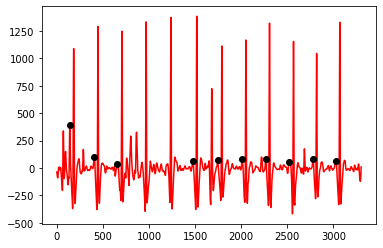

In [80]:
plt.plot(np.arange(len(features_df_gt['filtered'][0])), features_df_gt['filtered'][0], '-r')
plt.plot(features_df_nk2['ppeaks'][0], features_df_gt['filtered'][0][p_peaks], 'ok')

In [27]:
p_peaks

array([ 141,  405,  658, 1476, 1746, 2009, 2267, 2522, 2780, 3026])

In [18]:
cons = features_df_nk2['rpeaks'][0]

In [19]:
np.where(cons == 1)

(array([ 183,  446,  706,  969, 1237, 1517, 1783, 2050, 2306, 2566, 2817,
        3068]),)

In [20]:
features_df_gt['rpeaks'][0]

array([ 183,  446,  706,  969, 1237, 1517, 1680, 1789, 2050, 2306, 2567,
       2817, 3068])

In [778]:
ooo = np.array(values_nk2[0]['ECG_Phase_Atrial'])

In [780]:
np.where(ooo==ooo)

(array([ 141,  142,  143, ..., 3066, 3067, 3068]),)

In [785]:
ooo[3066]

1.0

In [94]:
len(y_train_df[y_train_df['y'] == 0])

3030

# TSFRESH

In [1182]:
import tsfresh as ts

In [1205]:
len(features_df['filtered'][1])

8670

In [ ]:
df.columns[1:4]

In [1184]:
considered_ts = sample.transpose().reset_index(drop=True)
considered_ts = pd.DataFrame(considered_ts[considered_ts.columns[:2]]).dropna()

In [1185]:
considered_ts

,0,1
0,-863,-137
1,-860,-132
2,-857,-123
3,-854,-107
4,-851,-79
...,...,...
3296,84,-2
3297,118,-1
3298,147,0
3299,188,0


In [1201]:
sample.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
0,-863,-860,-857,-854,-851,-849,-846,-843,-838,-831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-137,-132,-123,-107,-79,-59,-45,-47,-70,-107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-727,-736,-748,-784,-831,-874,-917,-967,-1029,-1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-103,-98,-92,-87,-81,-77,-71,-65,-61,-59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2,-1,-3,-5,-7,-10,-12,-14,-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1186]:
considered_ts_1 = pd.DataFrame(sample.transpose().reset_index(drop=True)[0]).dropna()
considered_ts_2 = pd.DataFrame(sample.transpose().reset_index(drop=True)[1]).dropna()

In [1187]:
considered_ts_1['id'] = np.ones(len(considered_ts_1), dtype=int)
considered_ts_1['time'] = np.arange(len(considered_ts_1))

considered_ts_2['id'] = 2*np.ones(len(considered_ts_2), dtype=int)
considered_ts_2['time'] = np.arange(len(considered_ts_2))

In [1188]:
considered_ts_1 = considered_ts_1.rename(columns={0: 'data'})
considered_ts_1['data'] = considered_ts_1['data'].apply(lambda x: float(x))

considered_ts_2 = considered_ts_2.rename(columns={1: 'data'})
considered_ts_2['data'] = considered_ts_2['data'].apply(lambda x: float(x))

In [1189]:
considered_ts = pd.concat([considered_ts_1, considered_ts_2], axis=0)

In [1190]:
considered_ts

,data,id,time
0,-863.0,1,0
1,-860.0,1,1
2,-857.0,1,2
3,-854.0,1,3
4,-851.0,1,4
...,...,...,...
8665,-47.0,2,8665
8666,-46.0,2,8666
8667,-45.0,2,8667
8668,-44.0,2,8668


In [1191]:
from tsfresh.feature_extraction import EfficientFCParameters

In [1193]:
settings = EfficientFCParameters()

In [1194]:
extracted_features_ts = ts.extract_features(considered_ts, column_id="id", column_sort="time", column_value='data')

Feature Extraction: 100%|██████████| 2/2 [00:55<00:00, 27.57s/it]


In [1195]:
extracted_features_ts_efficient = ts.extract_features(considered_ts, default_fc_parameters=settings, column_id="id", column_sort="time", column_value='data')

Feature Extraction: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [1200]:
extracted_features_ts_efficient

,data__variance_larger_than_standard_deviation,data__has_duplicate_max,data__has_duplicate_min,data__has_duplicate,data__sum_values,data__abs_energy,data__mean_abs_change,data__mean_change,data__mean_second_derivative_central,data__median,...,data__fourier_entropy__bins_2,data__fourier_entropy__bins_3,data__fourier_entropy__bins_5,data__fourier_entropy__bins_10,data__fourier_entropy__bins_100,data__permutation_entropy__dimension_3__tau_1,data__permutation_entropy__dimension_4__tau_1,data__permutation_entropy__dimension_5__tau_1,data__permutation_entropy__dimension_6__tau_1,data__permutation_entropy__dimension_7__tau_1
1,1.0,0.0,0.0,1.0,113992.0,341122010.0,19.277576,0.331515,0.006062,-1.0,...,0.138228,0.243347,0.390563,0.569504,1.002290,0.952076,1.229418,1.515554,1.809260,2.112117
2,1.0,0.0,0.0,1.0,10707.0,93613215.0,8.777944,0.010843,-0.000231,-22.0,...,0.110453,0.190068,0.414616,0.625228,1.127632,0.968576,1.329273,1.708556,2.106837,2.520538


In [835]:
len(extracted_features_ts.columns)

779

In [831]:
considered_ts

,data,id,time
0,-863.0,1,0
1,-860.0,1,1
2,-857.0,1,2
3,-854.0,1,3
4,-851.0,1,4
...,...,...,...
3296,84.0,1,3296
3297,118.0,1,3297
3298,147.0,1,3298
3299,188.0,1,3299


In [828]:
type(np.array(considered_ts['data'])[-1])

float

In [865]:
sample

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17969,x17970,x17971,x17972,x17973,x17974,x17975,x17976,x17977,x17978
0,-863,-860,-857,-854,-851,-849,-846,-843,-838,-831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-137,-132,-123,-107,-79,-59,-45,-47,-70,-107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-727,-736,-748,-784,-831,-874,-917,-967,-1029,-1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-103,-98,-92,-87,-81,-77,-71,-65,-61,-59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2,-1,-3,-5,-7,-10,-12,-14,-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,85,78,70,58,39,19,-7,-39,-63,-81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,7,6,6,5,5,5,5,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10,6,2,0,-3,-6,-9,-12,-15,-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1279,1306,1336,1369,1396,1414,1416,1401,1361,1310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-52,-50,-48,-47,-45,-42,-40,-39,-38,-37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1207]:
length_ts = len(sample)

In [1209]:
start = time.time()

length_ts = len(sample)
end_dfs_ts = []
pbar = tqdm(total = length_ts)
pbar.update(0)

for i in range(length_ts):
    pbar.update(1)
    
    sample_ts = pd.DataFrame(sample.transpose().reset_index(drop=True)[i]).dropna()
    sample_ts['id'] = i * np.ones(len(sample_ts), dtype=int)
    sample_ts['time'] = np.arange(len(sample_ts))
    sample_ts = sample_ts.rename(columns={i: 'data'})
    sample_ts['data'] = sample_ts['data'].apply(lambda x: float(x))
    end_dfs_ts.append(sample_ts)
    
end = time.time()
print(end-start)
    

6.281252145767212


In [1210]:
length_ts

30

In [1211]:
input_ts = pd.concat(end_dfs_ts, axis=0)

In [1214]:
start = time.time()

extracted_features_ts = ts.extract_features(input_ts, default_fc_parameters=settings, column_id="id", column_sort="time", column_value='data')

end = time.time()
print(f'TOTAL TIME: {end-start}')


Feature Extraction: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]

TOTAL TIME: 26.060373067855835


In [1215]:
extracted_features_ts

,data__variance_larger_than_standard_deviation,data__has_duplicate_max,data__has_duplicate_min,data__has_duplicate,data__sum_values,data__abs_energy,data__mean_abs_change,data__mean_change,data__mean_second_derivative_central,data__median,...,data__fourier_entropy__bins_2,data__fourier_entropy__bins_3,data__fourier_entropy__bins_5,data__fourier_entropy__bins_10,data__fourier_entropy__bins_100,data__permutation_entropy__dimension_3__tau_1,data__permutation_entropy__dimension_4__tau_1,data__permutation_entropy__dimension_5__tau_1,data__permutation_entropy__dimension_6__tau_1,data__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,113992.0,3.411220e+08,19.277576,0.331515,0.006062,-1.0,...,0.138228,0.243347,0.390563,0.569504,1.002290,0.952076,1.229418,1.515554,1.809260,2.112117
1,1.0,0.0,0.0,1.0,10707.0,9.361322e+07,8.777944,0.010843,-0.000231,-22.0,...,0.110453,0.190068,0.414616,0.625228,1.127632,0.968576,1.329273,1.708556,2.106837,2.520538
2,1.0,0.0,1.0,1.0,157468.0,4.513148e+08,16.486599,0.082549,-0.000357,-14.0,...,0.045395,0.090729,0.200814,0.378036,1.046962,0.956952,1.262045,1.589677,1.937743,2.300489
3,1.0,0.0,0.0,1.0,68795.0,3.721860e+08,12.793738,0.021693,-0.000645,-4.0,...,0.138228,0.243347,0.365192,0.543862,1.035410,0.998601,1.340385,1.701459,2.076842,2.460599
4,1.0,0.0,0.0,1.0,217352.0,2.012028e+09,15.138361,0.063794,-0.002552,11.0,...,0.045395,0.045395,0.090729,0.136002,0.290926,0.959419,1.252141,1.559158,1.877624,2.194856
5,1.0,0.0,0.0,1.0,-69520.0,1.079683e+08,13.125838,-0.007409,0.000588,-16.0,...,0.110453,0.159721,0.493901,0.769833,1.390605,0.984939,1.327191,1.698169,2.096347,2.518939
6,1.0,1.0,1.0,1.0,209514.0,1.032537e+08,5.089807,-0.003717,0.000061,-10.0,...,0.138228,0.243347,0.387044,0.539806,0.929142,1.065069,1.446335,1.834532,2.235529,2.648631
7,1.0,0.0,1.0,1.0,201068.0,2.249501e+08,11.708491,0.001651,-0.000059,2.0,...,0.272669,0.396337,0.511716,0.736706,1.232125,1.048521,1.454482,1.889157,2.350407,2.831499
8,1.0,0.0,1.0,1.0,251685.0,4.895008e+08,12.285079,-0.114556,-0.001425,10.5,...,0.045395,0.090729,0.183378,0.280179,0.883126,0.850035,1.107404,1.380728,1.669809,1.965390
9,1.0,0.0,1.0,1.0,155076.0,1.644294e+08,7.915817,0.001679,0.000000,-12.0,...,0.138228,0.247940,0.318449,0.512138,1.102083,1.055653,1.474651,1.924330,2.395505,2.887870


In [873]:
input_ts

,data,id,time
0,-863.0,0,0
1,-860.0,0,1
2,-857.0,0,2
3,-854.0,0,3
4,-851.0,0,4
...,...,...,...
16645,-74.0,29,16645
16646,-74.0,29,16646
16647,-73.0,29,16647
16648,-72.0,29,16648


In [1223]:
sample_ts

,data,id,time
0,67.0,29,0
1,71.0,29,1
2,74.0,29,2
3,76.0,29,3
4,77.0,29,4
...,...,...,...
16645,-74.0,29,16645
16646,-74.0,29,16646
16647,-73.0,29,16647
16648,-72.0,29,16648


In [ ]:
features_df.iloc[0][]

In [1225]:
np.arange(len(features_df.iloc[0]['filtered']), dtype=int)

array([   0,    1,    2, ..., 3298, 3299, 3300])

In [1230]:
pd.DataFrame(features_df.iloc[0]['filtered'])

,0
0,-36.353155
1,-42.652159
2,-48.948029
3,-55.387427
4,-62.210459
...,...
3296,-79.106906
3297,-61.402081
3298,-40.326832
3299,-16.215991


In [1229]:
features_df.iloc[0]['filtered'].reshape(len(features_df.iloc[0]['filtered']), 1)

array([[-36.3531551 ],
       [-42.65215944],
       [-48.94802932],
       ...,
       [-40.32683198],
       [-16.21599087],
       [  9.7306823 ]])

In [ ]:
start = time.time()

length_ts = len(sample)
end_dfs_ts = []
pbar = tqdm(total = length_ts)
pbar.update(0)

for i in range(length_ts):
    pbar.update(1)
    
    sample_ts = pd.DataFrame(sample.transpose().reset_index(drop=True)[i]).dropna()
    sample_ts['id'] = i * np.ones(len(sample_ts), dtype=int)
    sample_ts['time'] = np.arange(len(sample_ts))
    sample_ts = sample_ts.rename(columns={i: 'data'})
    sample_ts['data'] = sample_ts['data'].apply(lambda x: float(x))
    end_dfs_ts.append(sample_ts)
    
end = time.time()
print(end-start)

In [427]:
def extract_features(ecg_df, save=False, mode='train'):
    '''
    input: raw X_train_df
    '''
    ecg_df = ecg_df.drop('id', axis=1)

    features_names_timehvr = ['sdNN', 'meanNN', 'CVSD', 'cvNN', 'RMSSD', 'medianNN',
                              'madNN', 'mcvNN', 'pNN50', 'pNN20']

    # MAIN FEATURES, INITIALIZING #
    values = ecg_df.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)
    features_df = pd.DataFrame({'rpeaks': values.apply(lambda x: x['rpeaks']),
                                'filtered': values.apply(lambda x: x['filtered']),
                                'templates': values.apply(lambda x: x['templates'])})

    # R PEAK FEATURES
    features_df['R_peaks'] = features_df.apply(lambda x: x['filtered'][x['rpeaks']], axis=1)

    features_df['mean_rvalues'] = features_df.apply(lambda x: np.mean(x['R_peaks']), axis=1)
    features_df['min_rvalues'] = features_df.apply(lambda x: np.min(x['R_peaks']), axis=1)
    features_df['max_rvalues'] = features_df.apply(lambda x: np.max(x['R_peaks']), axis=1)
    features_df['std_rvalues'] = features_df.apply(lambda x: np.std(x['R_peaks']), axis=1)
    features_df['median_rvalues'] = features_df.apply(lambda x: np.median(x['R_peaks']), axis=1)

    # POWER
    features_df['power'] = features_df['filtered'].apply(lambda x: np.sum(np.square(x)) / x.shape[0])

    # CARDIADIC CYCLES
    # features_df['Cardiadic_Cycles'] = features_df['templates'].apply(lambda x: x)
    features_df['mean'] = features_df['templates'].apply(lambda x: np.mean(np.mean(x, axis=0)))
    features_df['mean_max'] = features_df['templates'].apply(lambda x: np.mean(np.max(x, axis=0)))
    features_df['mean_min'] = features_df['templates'].apply(lambda x: np.mean(np.min(x, axis=0)))
    features_df['mean_median'] = features_df['templates'].apply(lambda x: np.mean(np.median(x, axis=0)))
    features_df['mean_std'] = features_df['templates'].apply(lambda x: np.mean(np.std(x.astype(np.float), axis=0)))

    features_df['max_min'] = features_df['templates'].apply(lambda x: np.max(np.min(x, axis=0)))
    features_df['min_min'] = features_df['templates'].apply(lambda x: np.min(np.min(x, axis=0)))

    features_df['max_max'] = features_df['templates'].apply(lambda x: np.max(np.max(x, axis=0)))
    features_df['min_max'] = features_df['templates'].apply(lambda x: np.min(np.max(x, axis=0)))

    features_df['min_std'] = features_df['templates'].apply(lambda x: np.min(np.std(x.astype(np.float), axis=0)))
    features_df['max_std'] = features_df['templates'].apply(lambda x: np.max(np.std(x.astype(np.float), axis=0)))

    # HRV FEATURES
    features_df['hrv_time_features'] = features_df['rpeaks'].apply(lambda x: ecg_hrv(rpeaks=x,
                                                                                     sampling_rate=300,
                                                                                     hrv_features='time'))
    for name in features_names_timehvr:
        features_df[name] = features_df['hrv_time_features'].apply(lambda x: x[name])

    # FINALIZE / SAVE
    features_df = features_df.drop(['rpeaks', 'filtered', 'templates', 'R_peaks', 'hrv_time_features'], axis=1)
    numberOfFeatures = len(features_df.columns)

    if save:
        features_df.to_csv('./features/features_'+mode+'_'+str(numberOfFeatures)+'.csv', index=False)

    return features_df

In [428]:
sample_2 = X_train_df.iloc[:100,:]

In [429]:
start = time.time()

features_2 = extract_features(sample_2)

end = time.time()
print(end - start)

10.333795070648193


# BRNN SETUP

In [899]:
mitbih_data_train = pd.read_csv('./sklearn_models/mlfhc/data/archive/mitbih_train.csv')

In [933]:
index = 8

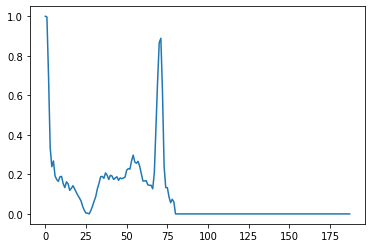

In [934]:
plt.plot(np.arange(len(np.array(mitbih_data_train.iloc[index]))), np.array(mitbih_data_train.iloc[index]))

In [936]:
len(np.array(mitbih_data_train.iloc[index]))

188

In [939]:
values_all = sample_all.apply(lambda x: ecg.ecg(x.dropna(), sampling_rate=300, show=False), axis=1)
features_df = pd.DataFrame({'rpeaks': values_all.apply(lambda x: x['rpeaks']),
                            'filtered': values_all.apply(lambda x: x['filtered']),
                            'templates': values_all.apply(lambda x: x['templates'])})

180
180
180
180
180
180
180
180
180
180
180
180
180


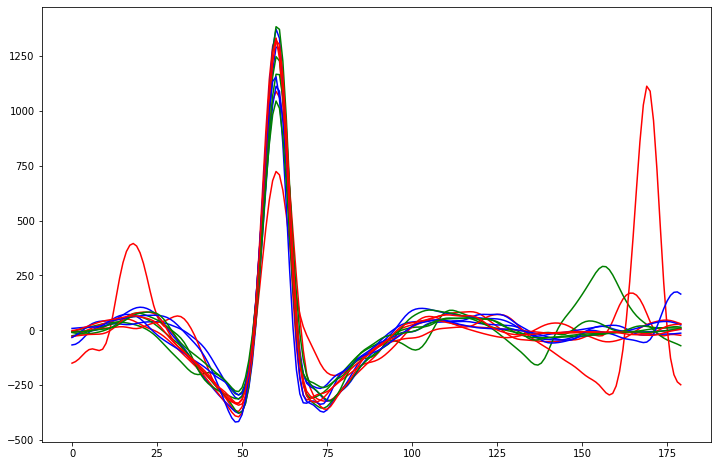

In [945]:
colors = ['r', 'b', 'g']

plt.figure(figsize=(12,8))
for i, temp in enumerate(features_df['templates'][0]):
    print(len(temp))
    plt.plot(np.arange(len(temp)), temp, colors[i%3])
    #if i == 2:
    #    break

In [948]:
train_all = pd.concat([features_df, y_train_df], axis=1)

In [993]:
train_all.head(10)

,rpeaks,filtered,templates,id,y
0,"[183, 446, 706, 969, 1237, 1517, 1680, 1789, 2...","[-36.35315510258832, -42.65215944435597, -48.9...","[[-149.8461756509217, -142.86810193402488, -13...",0,0
1,"[76, 343, 639, 944, 1238, 1513, 1761, 2008, 22...","[-5.771010717328617, -8.184503629133387, -2.69...","[[-64.60771453704189, -39.39772357225713, -9.8...",1,0
2,"[259, 468, 677, 885, 1094, 1308, 1529, 1751, 1...","[-30.624268551079602, -12.782267799767025, -1....","[[5.686957561503886, -6.140703221431292, -14.9...",2,0
3,"[305, 559, 827, 1075, 1368, 1650, 1938, 2177, ...","[-4.338789079451445, 2.3249872820251194, 8.698...","[[-14.899667069219474, -13.91482548030478, -14...",3,2
4,"[135, 420, 726, 1088, 1364, 1662, 1981, 2256, ...","[0.33699332655933467, -5.365099622647967, -10....","[[19.907135756915842, 20.620762841806076, 20.9...",4,0
5,"[95, 258, 428, 602, 781, 951, 1116, 1278, 1443...","[3.580554094692939, 10.808448124131765, 15.465...","[[23.819164738787997, 37.01128286501253, 45.95...",5,2
6,"[313, 611, 847, 1050, 1322, 1609, 1894, 2190, ...","[0.336993326559339, -8.634463471182299, -17.34...","[[-7.172081522970656, -6.734984705010079, -6.2...",6,0
7,"[307, 574, 842, 1110, 1379, 1647, 1916, 2181, ...","[0.42124165819917136, -2.170899891983642, -4.6...","[[48.13262796493155, 50.312743458581984, 50.04...",7,0
8,"[343, 617, 907, 1200, 1497, 1780, 2070, 2367, ...","[53.87680808367379, 111.61524531542449, 170.70...","[[-40.29815426473136, -38.893844671119716, -33...",8,0
9,"[78, 288, 615, 946, 1269, 1584, 1906, 2228, 25...","[-2.19045662263568, -3.701106503865905, -5.397...","[[16.098998443231807, 23.69739962803508, 28.89...",9,2


In [1015]:
train_all['mean_template'] = train_all['templates'].apply(lambda x: x.mean(axis=0))

In [1086]:
train_arr_brnn = np.array([temp for temp in train_all['mean_template']])

In [1087]:
train_arr_brnn = np.reshape(train_arr_brnn, (len(train_arr_brnn), 180, 1))

In [1088]:
train_arr_brnn.shape

(5117, 180, 1)

In [1089]:
y_train_brnn = train_all['y'].values.ravel()

In [1090]:
y_train_brnn.shape

(5117,)

In [1091]:
X_tr_brnn = train_arr_brnn[:4500,:,:]
X_te_brnn = train_arr_brnn[4500:,:,:]

y_tr_brnn = y_train_brnn[:4500]
y_te_brnn = y_train_brnn[4500:]

y_tr_brnn = np_utils.to_categorical(y_train_brnn)

In [1092]:
y_tr_brnn.shape

(5117, 4)

In [1093]:
#Add seed for reproducibility
from numpy.random import seed
seed(1)
import tensorflow as tf 
tf.random.set_seed(2)

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Bidirectional
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score

In [1128]:
#Define model 
def get_model(inp_shape = 180):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True), input_shape=(inp_shape, 1)))
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(64, return_sequences=False)))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(4, activation='softmax'))
    model.summary()

    return model

In [1102]:
#Configure model 
model = get_model()
opt = Adam(lr=0.001)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 180, 128)          8448      
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 180, 128)          24704     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128)               24704     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 260       
Total params: 70,532
Trainable params: 70,532
Non-trainable params: 0
__________________________________________________

In [1103]:
#Define callbacks
#check = ModelCheckpoint(path_model, monitor='val_acc', save_best_only=True, mode='max', verbose=2)
early = EarlyStopping(monitor='val_acc', mode='max', patience=6, verbose=2)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, verbose=2)

In [1104]:
EPOCH = 5

In [1105]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.fit(X_tr_brnn, y_tr_brnn, epochs=EPOCH, batch_size=64, callbacks=[early, reduce_lr],
          validation_split=0.1)

Epoch 1/5
64/64 [==============================] - 12s 180ms/step - loss: 1.5299 - acc: 0.5706 - val_loss: 0.9443 - val_acc: 0.6289
Epoch 2/5
64/64 [==============================] - 11s 167ms/step - loss: 1.0321 - acc: 0.5877 - val_loss: 0.9366 - val_acc: 0.6289
Epoch 3/5
64/64 [==============================] - 11s 166ms/step - loss: 1.0108 - acc: 0.5877 - val_loss: 0.9350 - val_acc: 0.6289
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 1.0061 - acc: 0.5877
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.020000000298023225.
64/64 [==============================] - 11s 177ms/step - loss: 1.0061 - acc: 0.5877 - val_loss: 0.9349 - val_acc: 0.6289
Epoch 5/5
64/64 [==============================] - 12s 184ms/step - loss: 1.0038 - acc: 0.5877 - val_loss: 0.9377 - val_acc: 0.6289


In [1099]:
#Get predictions for test dataset 
predictions = model.predict(X_te_brnn)

predictions = np.argmax(predictions, axis=-1)

In [1101]:
#Compute Accuracy 
acc = accuracy_score(predictions, y_te_brnn)
f1 = f1_score(predictions, y_te_brnn, average='micro')

print("Test accuracy score : %s " % acc)
print("Test f1 score : %s " % f1)

Test accuracy score : 0.6077795786061588 
Test f1 score : 0.6077795786061588 


# BRNN on raw data

In [1114]:
raw_filtered_brnn = np.array([filt[300:2520] for filt in features_df['filtered']])

In [1117]:
raw_filtered_brnn = raw_filtered_brnn.reshape(len(raw_filtered_brnn), 2220, 1)

In [1118]:
raw_filtered_brnn.shape

(5117, 2220, 1)

In [1119]:
X_tr_raw_brnn = raw_filtered_brnn[:4500,:,:]
X_te_raw_brnn = raw_filtered_brnn[4500:,:,:]

In [1133]:
#Configure model 
model = get_model(inp_shape = 2220)
opt = Adam(lr=0.001)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 2220, 128)         8448      
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 2220, 128)         24704     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               24704     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 260       
Total params: 70,532
Trainable params: 70,532
Non-trainable params: 0
__________________________________________________

In [1134]:
#Define callbacks
#check = ModelCheckpoint(path_model, monitor='val_acc', save_best_only=True, mode='max', verbose=2)
early = EarlyStopping(monitor='val_acc', mode='max', patience=6, verbose=2)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, verbose=2)

In [1135]:
EPOCH = 5

In [1136]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.fit(X_tr_raw_brnn, y_tr_brnn, epochs=EPOCH, batch_size=64, callbacks=[early, reduce_lr],
          validation_split=0.1)

Epoch 1/5
64/64 [==============================] - 250s 4s/step - loss: 1.0492 - acc: 0.5642 - val_loss: 0.9582 - val_acc: 0.6222
Epoch 2/5
64/64 [==============================] - 247s 4s/step - loss: 1.0136 - acc: 0.5867 - val_loss: 0.9408 - val_acc: 0.6311
Epoch 3/5
62/64 [============================>.] - ETA: 8s - loss: 1.0108 - acc: 0.5824 

KeyboardInterrupt: 

In [1125]:
#Get predictions for test dataset 
predictions = model.predict(X_te_raw_brnn)

predictions = np.argmax(predictions, axis=-1)

In [1126]:
#Compute Accuracy 
acc = accuracy_score(predictions, y_te_brnn)
f1 = f1_score(predictions, y_te_brnn, average='micro')

print("Test accuracy score : %s " % acc)
print("Test f1 score : %s " % f1)

Test accuracy score : 0.4619124797406807 
Test f1 score : 0.4619124797406807 


# CNN - LSTM

In [1144]:
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, LSTM, BatchNormalization

In [1145]:
#Define model 
def get_cnn_lstm_model(inp_shape = 180):
    number_labels = 4
    inp = Input(shape=(inp_shape, 1))

    forward = Convolution1D(filters=16, kernel_size=3, strides=1, padding='same', activation=activations.relu)(inp)
    forward = Convolution1D(filters=32, kernel_size=3, strides=1, padding='same', activation=activations.relu)(forward)
    forward = MaxPool1D(pool_size=2)(forward)
    forward = Dropout(rate=0.2)(forward)

    forward = Convolution1D(filters=64, kernel_size=3, strides=1, padding='same', activation=activations.relu)(forward)
    forward = Convolution1D(filters=128, kernel_size=3, strides=1, padding='same', activation=activations.relu)(forward)
    forward = MaxPool1D(pool_size=2)(forward)
    forward = Dropout(rate=0.3)(forward)

    forward = Convolution1D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)(forward)
    #forward = Convolution1D(filters=512, kernel_size=3, strides=1, padding='same', activation=activations.relu)(forward)
    forward = MaxPool1D(pool_size=2)(forward)
    forward = Dropout(rate=0.4)(forward)

    forward = LSTM(units=32, activation='tanh', return_sequences=True)(forward)
    forward = BatchNormalization()(forward)
    forward = LSTM(units=32, activation='tanh', return_sequences=False)(forward)
    forward = BatchNormalization()(forward)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(forward)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(number_labels, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [1154]:
#Configure model 
model = get_cnn_lstm_model()
opt = Adam(lr=0.0001)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 180, 16)           64        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 180, 32)           1568      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 90, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 90, 64)            6208      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 90, 128)          

In [1155]:
#Define callbacks
#check = ModelCheckpoint(path_model, monitor='val_acc', save_best_only=True, mode='max', verbose=2)
early = EarlyStopping(monitor='val_acc', mode='max', patience=6, verbose=2)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, verbose=2)

In [1156]:
EPOCH = 5

In [1157]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.fit(X_tr_brnn, y_tr_brnn, epochs=EPOCH, batch_size=64, callbacks=[early, reduce_lr],
          validation_split=0.1)

Epoch 1/5
64/64 [==============================] - 5s 82ms/step - loss: 1.2037 - acc: 0.5168 - val_loss: 1.2989 - val_acc: 0.6222
Epoch 2/5
64/64 [==============================] - 4s 67ms/step - loss: 1.0970 - acc: 0.5746 - val_loss: 1.1679 - val_acc: 0.6289
Epoch 3/5
64/64 [==============================] - 4s 68ms/step - loss: 1.0458 - acc: 0.5753 - val_loss: 1.0375 - val_acc: 0.6289
Epoch 4/5
64/64 [==============================] - 4s 67ms/step - loss: 1.0345 - acc: 0.5780 - val_loss: 0.9706 - val_acc: 0.6311
Epoch 5/5
64/64 [==============================] - 4s 68ms/step - loss: 1.0185 - acc: 0.5869 - val_loss: 0.9173 - val_acc: 0.6289


In [1158]:
#Get predictions for test dataset 
predictions = model.predict(X_te_brnn)

predictions = np.argmax(predictions, axis=-1)

In [1159]:
#Compute Accuracy 
acc = accuracy_score(predictions, y_te_brnn)
f1 = f1_score(predictions, y_te_brnn, average='micro')

print("Test accuracy score : %s " % acc)
print("Test f1 score : %s " % f1)

Test accuracy score : 0.5948136142625607 
Test f1 score : 0.5948136142625607 


In [1162]:
len(y_train_df[y_train_df['y'] == 0]) / len(y_train_df)

0.5921438342778972

# testing features

In [ ]:
# BEST VAL SCORE: ovr(xgb), no outlier, feature kbest(40)

In [ ]:
# best until now: random forest with feature select, outlier but without class imbalance (for 27 features)

In [2244]:
#features_train_43 = pd.read_csv('./sklearn_models/features/features_train_43.csv')
#features_test_43 = pd.read_csv('./sklearn_models/features/features_test_43.csv')

features_train = pd.read_csv('./sklearn_models/features/features_train_43.csv')
features_test = pd.read_csv('./sklearn_models/features/features_test_43.csv')

In [2022]:
'''
# TRY WITH REDUCED FEATURES

cols_to_drop = ['extra1', 'extra2', 'extra3', 'extra4', 'extra5',
       'corr_max', 'corr_min', 'corr1', 'corr2', 'corr3']

features_train = features_train.drop(cols_to_drop, axis = 1)
features_test = features_test.drop(cols_to_drop, axis = 1'
'''

"\n# TRY WITH REDUCED FEATURES\n\ncols_to_drop = ['extra1', 'extra2', 'extra3', 'extra4', 'extra5',\n       'corr_max', 'corr_min', 'corr1', 'corr2', 'corr3']\n\nfeatures_train = features_train.drop(cols_to_drop, axis = 1)\nfeatures_test = features_test.drop(cols_to_drop, axis = 1'\n"

In [2023]:
'''
# USING ALL FEATURES #

features_train_47 = pd.read_csv('./sklearn_models/features/features_train_47.csv')
features_test_47 = pd.read_csv('./sklearn_models/features/features_test_47.csv')

cols_to_use = features_test_47.columns.difference(features_train_43.columns)

features_train = pd.concat([features_train_43, features_train_47[cols_to_use]], axis=1)
features_test = pd.concat([features_test_43, features_test_47[cols_to_use]], axis=1)
'''

"\n# USING ALL FEATURES #\n\nfeatures_train_47 = pd.read_csv('./sklearn_models/features/features_train_47.csv')\nfeatures_test_47 = pd.read_csv('./sklearn_models/features/features_test_47.csv')\n\ncols_to_use = features_test_47.columns.difference(features_train_43.columns)\n\nfeatures_train = pd.concat([features_train_43, features_train_47[cols_to_use]], axis=1)\nfeatures_test = pd.concat([features_test_43, features_test_47[cols_to_use]], axis=1)\n"

In [2245]:
train_all = pd.concat([features_train, y_train_df], axis=1).drop('id', axis=1).dropna(axis=0).reset_index(drop=True)
##drop class 3
##train_all = train_all[train_all['y'] != 3].reset_index(drop=True)
#features_y_train = train_all.iloc[:4500]
#features_y_train = features_y_train[features_y_train['y'] != 3].reset_index(drop=True)
#features_y_test = train_all.iloc[4500:]
#
#X_tr = features_y_train.drop('y',axis=1).values
#y_tr = features_y_train['y'].values.ravel()
#
#X_te = features_y_test.drop('y',axis=1).values
#y_te = features_y_test['y'].values.ravel()
#############
features_train = train_all.drop('y', axis=1)
y_train = train_all['y'].values.ravel()

#y_train = y_train_df.drop('id', axis=1).values.ravel()

In [2246]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

from sklearn.multiclass import OneVsRestClassifier

In [2247]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.ensemble import IsolationForest

In [2248]:
def isof(x, y):
    model = IsolationForest()
    y_pred = model.fit_predict(x)
    return x[y_pred == 1], y[y_pred == 1]

In [2249]:
features = features_train.values

X_tr = features[:4000,:]
y_tr = y_train[:4000]

X_te = features[4000:,:]
y_te = y_train[4000:]

In [2250]:
# remove const columns

tresh = VarianceThreshold(threshold=0)
X_tr = tresh.fit_transform(X_tr)

In [2251]:
# scaling

scale = StandardScaler()
X_tr = scale.fit_transform(X_tr)

In [2198]:
# outlier detection

X_tr, y_tr = isof(X_tr, y_tr)

In [2252]:
# feature selection

#from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect
#
#selection = GenericUnivariateSelect(mode='fdr', param=0.2)#, param=0.1, mode='fwe','fdr','fpr')
#X_tr = selection.fit_transform(X_tr, y_tr)

#selection = KernelPCA(kernel='rbf', n_components=40)
#X_tr = selection.fit_transform(X_tr)


from sklearn.feature_selection import SelectKBest, f_classif

if True:
    inputDim = 40
    selection = SelectKBest(f_classif, k = inputDim)
    X_tr = selection.fit_transform(X_tr, y_tr)
    scores = featureSelection.scores_
    print("Shape after feature selection: ", X_tr.shape)

Shape after feature selection:  (4000, 40)


In [2253]:
# class imbalance

#from imblearn.combine import SMOTEENN, SMOTETomek
#sampler = SMOTEENN()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

#from imblearn.under_sampling import RandomUnderSampler
#sampler = RandomUnderSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

#from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [2254]:
## feature selection
#
#from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect
#
#selection = GenericUnivariateSelect(mode='fwe', param=0.1)#, param=0.1, mode='fwe','fdr','fpr')
#X_tr = selection.fit_transform(X_tr, y_tr)
#
##selection = KernelPCA(kernel='rbf', n_components=300)
##X_tr = selection.fit_transform(X_tr)

In [2255]:
## scaling
#
#scale = StandardScaler()
#X_tr = scale.fit_transform(X_tr)

In [2256]:
param_grid_svc = [
    {
        'C':[0.1,1,10],
        'kernel':['rbf']
    }
]

In [2257]:
# initial test SVC try 'fdr' with svc
clf = SVC()
search = GridSearchCV(clf, param_grid=param_grid_svc, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [2258]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    3.8s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    3.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.0s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['rbf']}],
             scoring='f1_micro', verbose=10)

In [2259]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.7797496600536942
Best parameters set: {'C': 10, 'kernel': 'rbf'}


In [2260]:
X_te = tresh.transform(X_te)
#X_te = selection.transform(X_te)
#X_te = scale.transform(X_te)

X_te = scale.transform(X_te)
X_te = selection.transform(X_te)

In [2261]:
# novelty detection

from sklearn.ensemble import IsolationForest

detector = IsolationForest(random_state=0)
outliers = detector.fit_predict(X_te)

print(len(np.where(outliers==-1)[0]))
print(len(np.where(y_te == 3)[0]))

In [2264]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.7994628469113697


In [2178]:
# ------------------------------------

In [2266]:
param_grid_xgb = [
    {
        'estimator__max_depth':[3]
    }
]
#param_grid_xgb = [
#    {
#        'max_depth':[10]
#    }
#]

In [2267]:
# initial test XGBClassifier
clf = OneVsRestClassifier(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1))
#clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                                colsample_bynode=1, colsample_bytree=1, gamma=0,
#                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
#                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#                                n_jobs=1, nthread=None, random_state=0,
#                                reg_alpha=0, reg_lambda=1, seed=None,
#                                silent=None, subsample=1, verbosity=1)
#clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                                colsample_bynode=1, colsample_bytree=1, gamma=0,
#                                importance_type='gain', learning_rate=0.05, max_delta_step=3,
#                                max_depth=10, min_child_weight=11, missing=None, n_estimators=400,
#                                n_jobs=1, nthread=None, random_state=0,
#                                reg_alpha=0, reg_lambda=1, seed=1111,
#                                silent=None, subsample=1, verbosity=1, num_class=4)
search = GridSearchCV(clf, param_grid=param_grid_xgb, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [ ]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

In [ ]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

In [192]:
'''

# create initial sumbmission

features_out = features.copy()
y_train_out = y_train_df.drop('id', axis=1).values
y_train_out = y_train_out.reshape(len(y_train_out))

# outlier detection
features_out, y_train_out = isof(features_out, y_train_out)

# class imbalance
#from imblearn.under_sampling import RandomUnderSampler
#sampler = RandomUnderSampler()
#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)

#from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler()
#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)

#from imblearn.combine import SMOTEENN, SMOTETomek
#sampler = SMOTEENN()
#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)

## feature selection
#from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect
#
#selection = GenericUnivariateSelect(mode='fdr', param=0.1)#, param=0.1, mode='fwe')
#features_out = y_train_out.fit_transform(features_out, y_train_out)

# scaling
scale = StandardScaler()
features_out = scale.fit_transform(features_out)

param_grid_xgb = [
    {
        'estimator__max_depth':[3]
    }
]

# initial test XGBClassifier
clf = OneVsRestClassifier(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1))
search = GridSearchCV(clf, param_grid=param_grid_xgb, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

search.fit(features_out, y_train_out)

print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

X_test_out = features_test.values
#X_test_out = thresh.transform(X_test_out)
#X_test_out = selection.transform(X_test_out)
X_test_out = scale.transform(X_test_out)

predicted = search.predict(X_test_out)

'''

'\n\n# create initial sumbmission\n\nfeatures_out = features.copy()\ny_train_out = y_train_df.drop(\'id\', axis=1).values\ny_train_out = y_train_out.reshape(len(y_train_out))\n\n# outlier detection\nfeatures_out, y_train_out = isof(features_out, y_train_out)\n\n# class imbalance\n#from imblearn.under_sampling import RandomUnderSampler\n#sampler = RandomUnderSampler()\n#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)\n\n#from imblearn.over_sampling import RandomOverSampler\n#sampler = RandomOverSampler()\n#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)\n\n#from imblearn.combine import SMOTEENN, SMOTETomek\n#sampler = SMOTEENN()\n#features_out, y_train_out = sampler.fit_resample(features_out, y_train_out)\n\n## feature selection\n#from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect\n#\n#selection = GenericUnivariateSelect(mode=\'fdr\', param=0.1)#, param=0.1, mode=\'fwe\')\n#features_out = y_train_out.f

In [193]:
#predicted = pd.DataFrame(predicted)
#predicted.to_csv('prediction.csv', index_label='id', header=['y'], compression=None)

In [194]:
# ------------------------------------

In [195]:
param_grid_svc = [
    {
        'estimator__C':[0.1,1,10],
        'estimator__kernel':['rbf']
    }
]

In [196]:
# initial test SVC try 'fdr' with svc
clf = OneVsRestClassifier(estimator = SVC(class_weight='balanced'))
search = GridSearchCV(clf, param_grid=param_grid_svc, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [197]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    1.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    1.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.9s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SVC(class_weight='balanced')),
             n_jobs=-1,
             param_grid=[{'estimator__C': [0.1, 1, 10],
                          'estimator__kernel': ['rbf']}],
             scoring='f1_micro', verbose=10)

In [198]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.7662207196564451
Best parameters set: {'estimator__C': 10, 'estimator__kernel': 'rbf'}


In [199]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.7555953446732319


In [ ]:
# ------------------------------------

In [1363]:
from sklearn.neural_network import MLPClassifier

In [1364]:
param_grid_nn = [
    {
        'estimator__hidden_layer_sizes':[(60,), (60,60), (80,)]#, tuple(150*np.ones(3, dtype=int))]
    } # best (70,70,70)
]

In [1365]:
# initial test NN
clf = OneVsRestClassifier(estimator=MLPClassifier(activation='relu', alpha=1))
search = GridSearchCV(clf, param_grid=param_grid_nn, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [1366]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   15.2s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   15.6s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.4s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   17.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   20.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   20.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   23.0s finished
/opt/anaconda3/envs/working/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=MLPClassifier(alpha=1)),
             n_jobs=-1,
             param_grid=[{'estimator__hidden_layer_sizes': [(60,), (60, 60),
                                                            (80,)]}],
             scoring='f1_micro', verbose=10)

In [1367]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.7934245179884715
Best parameters set: {'estimator__hidden_layer_sizes': (60, 60)}


In [1368]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.7896150402864816


In [1369]:
# ------------------------------------

In [1370]:
from sklearn.ensemble import RandomForestClassifier

In [1371]:
param_grid_rf = [
    {
        'estimator__min_samples_split':[2]
    }
]

In [1372]:
# initial test RandomForest
clf = OneVsRestClassifier(estimator=RandomForestClassifier())
search = GridSearchCV(clf, param_grid=param_grid_rf, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [1373]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1, param_grid=[{'estimator__min_samples_split': [2]}],
             scoring='f1_micro', verbose=10)

In [1374]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.8113313833542382
Best parameters set: {'estimator__min_samples_split': 2}


In [1375]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.8146821844225605


In [1376]:
# ------------------------------------

In [1377]:
from sklearn.ensemble import ExtraTreesClassifier

In [1378]:
param_grid_etc = [
    {
        'estimator__min_samples_split':[2]
    }
]

In [1379]:
# initial test ExtraTreesClassifier
clf = OneVsRestClassifier(estimator=ExtraTreesClassifier())
search = GridSearchCV(clf, param_grid=param_grid_etc, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [1380]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=ExtraTreesClassifier()),
             n_jobs=-1, param_grid=[{'estimator__min_samples_split': [2]}],
             scoring='f1_micro', verbose=10)

In [1381]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.796099956134038
Best parameters set: {'estimator__min_samples_split': 2}


In [1382]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.7985675917636527


In [1383]:
# ------------------------------------

In [1384]:
from sklearn.ensemble import StackingClassifier

In [1385]:
estimators = [#('mlp', MLPClassifier(hidden_layer_sizes=(60,60))),
                                 ('rf', RandomForestClassifier(min_samples_split=2)),
                                 ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                    n_jobs=1, nthread=None, random_state=0,
                                    reg_alpha=0, reg_lambda=1, seed=None,
                                    silent=None, subsample=1, verbosity=1))]
final_estimator = RandomForestClassifier(min_samples_split=2)

In [1386]:
param_grid_sc = [
    {
        'estimator__stack_method':['auto']
    }
]

In [1387]:
# initial test StackingClassifier
clf = OneVsRestClassifier(estimator=StackingClassifier(estimators=estimators, final_estimator=final_estimator))
search = GridSearchCV(clf, param_grid=param_grid_sc, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [1388]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                                     RandomForestClassifier()),
                                                                                    ('xgb',
                                                                                     XGBClassifier(base_score=0.5,
                                                                                                   booster='gbtree',
                                                                                                   colsample_bylevel=1,
                                                                                                   colsample_bynode=1,
                                                                                                   colsample_bytree=1,
                                                                                                

In [1389]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.7851413906195382
Best parameters set: {'estimator__stack_method': 'auto'}


In [1390]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.7949865711727843


# Berkays xgb

In [2222]:
train_all = pd.concat([features_train, y_train_df], axis=1).drop('id', axis=1).dropna(axis=0).reset_index(drop=True)
#train_all = train_all[train_all['y'] != 3]
features_train = train_all.drop('y', axis=1)
y_train = train_all['y'].values.ravel()

#y_train = y_train_df.drop('id', axis=1).values.ravel()

In [2223]:
features_train.values

array([[ 1.19796570e+03,  7.24009320e+02,  1.38417313e+03, ...,
        -2.57350864e-02,  7.37841768e-02, -1.44741624e-02],
       [ 4.17427199e+02,  3.00195396e+02,  5.56621689e+02, ...,
        -3.39926134e-03, -1.72635788e-02, -3.05474608e-03],
       [ 7.76414002e+02,  4.67725419e+02,  8.61248246e+02, ...,
         9.03534621e-02,  4.87697974e-02, -9.76148077e-03],
       ...,
       [ 3.20884357e+02,  2.47071872e+02,  3.96469067e+02, ...,
         1.10887274e-01,  2.18204430e-02, -8.98718855e-03],
       [ 1.18634524e+03,  1.09559150e+03,  1.30654254e+03, ...,
         5.51080653e-02,  3.40188228e-02, -3.85213811e-03],
       [ 2.85702330e+02,  8.82296956e+01,  5.27794873e+02, ...,
         8.65702668e-02,  9.95110976e-02, -1.54131506e-02]])

In [2239]:
# novelty detection

from sklearn.ensemble import IsolationForest

detector = IsolationForest(random_state=0, contamination = len(np.where(y_train==3)[0])/len(y_train))
outliers = detector.fit_predict(features_train.values)

In [2241]:
len(np.where(outliers == -1)[0])

170

In [2242]:
good = 0
for out in np.where(outliers == -1)[0]:
    if out in np.where(y_train==3)[0]:
        good += 1

In [2243]:
good

55

In [2185]:
print(features_train.values.shape)
print(y_train.shape)
print(features_test.values.shape)

(4947, 43)
(4947,)
(3411, 43)


In [2186]:
OUTLIER_DETECTION = False
FEATURE_SELECTION = True

X_train = features_train.values
X_test = features_test.values
y_train = train_all['y'].values.ravel()

print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

scaler = StandardScaler()
#normalizer = Normalizer()
#X_train = normalizer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

if OUTLIER_DETECTION:
    X_train, y_train = auxilary.OutlierDetectionIsolationForest(X_train, y_train, percentageOutlier = 0.002)


#auxilary.plotSFeatureScores(X_train, y_train, f_classif)
if FEATURE_SELECTION:
    inputDim = 40
    featureSelection = SelectKBest(f_classif, k = inputDim)
    X_train = featureSelection.fit_transform(X_train, y_train)
    scores = featureSelection.scores_
    print("Shape after feature selection: ", X_train.shape)




#scoreFunction = make_scorer(f1_score, average='micro', greater_is_better=True)

xgb_model = XGBClassifier()

parameters = {
    'objective': ['binary:logistic'],
    'max_depth': [10],
    'min_child_weight': [11],
    'n_estimators': [400],
    'seed': [1111],
    'learning_rate': [0.05],
    'max_delta_step': [3],
    'num_class': [4]
}

clf = GridSearchCV(estimator=xgb_model, param_grid=parameters, n_jobs=5, cv=3, scoring='f1_micro', verbose=2)
clf.fit(X_train, y_train)



print("Best score of best on validation set: ", clf.best_score_) #0.6670
print("Best Parameters: ", clf.best_params_) #rbf, 10

train shape:  (4947, 43)
test shape:  (3411, 43)
Shape after feature selection:  (4947, 40)


/opt/anaconda3/envs/working/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   35.1s finished


Best score of best on validation set:  0.8281786941580757
Best Parameters:  {'learning_rate': 0.05, 'max_delta_step': 3, 'max_depth': 10, 'min_child_weight': 11, 'n_estimators': 400, 'num_class': 4, 'objective': 'binary:logistic', 'seed': 1111}


In [2187]:
X_test = scaler.transform(X_test)
if FEATURE_SELECTION:
    X_test = featureSelection.transform(X_test)
y_pred_test = clf.predict(X_test)
print('Number of 3:', np.count_nonzero(y_pred_test == 3))

Number of 3: 0


In [2189]:
# Save prediction
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.to_csv('prediction_xgb_43_3.csv', index_label='id', header=['y'], compression=None)
print('Results saved as prediction_xgb_43_3.csv')

Results saved as prediction_xgb_43_3.csv


# ANOMALY DETECTOR OUTPUT

In [36]:
import torch

In [69]:
class Anomaly_Classifier(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super(Anomaly_Classifier, self).__init__()

        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1)

        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(output_size=14)

        self.dense1 = nn.Linear(32 * 14, 32)
        self.dense2 = nn.Linear(32, 32)

        self.dense_final = nn.Linear(32, num_classes)
        # self.softmax= nn.LogSoftmax(dim=1)

    def forward(self, x):
        residual = self.conv(x)

        # block1
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)  # [512 32 1156]

        # block2
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)  # [512 32 576]

        # block3
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)  # [512 32 286]

        # block4
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        x = self.maxpool(x)  # [512 32 141]

        x = self.avgpool(x)

        # MLP
        x = x.view(-1, 32 * 14)  # Reshape (current_dim, 32*2)
        x = F.relu(self.dense1(x))
        # x = self.drop_60(x)
        x = self.dense2(x)
        x = self.dense_final(x)
        # x = self.softmax(self.dense_final(x))
        return x

In [37]:
weights = torch.load('./checkpoints/AC0/best.pth')

In [44]:
weights['model_states']['net'].keys()

odict_keys(['conv.weight', 'conv.bias', 'conv_pad.weight', 'conv_pad.bias', 'dense1.weight', 'dense1.bias', 'dense2.weight', 'dense2.bias', 'dense_final.weight', 'dense_final.bias'])

In [ ]:
model = Anomaly_Classifier()

In [119]:
model.load_state_dict(weights['model_states']['net'])

<All keys matched successfully>

In [78]:
for child in model.named_children():
    print(child)

('conv', Conv1d(1, 32, kernel_size=(5,), stride=(1,)))
('conv_pad', Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,)))
('drop_50', Dropout(p=0.5, inplace=False))
('maxpool', MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False))
('avgpool', AdaptiveAvgPool1d(output_size=14))
('dense1', Linear(in_features=448, out_features=32, bias=True))
('dense2', Linear(in_features=32, out_features=32, bias=True))
('dense_final', Linear(in_features=32, out_features=4, bias=True))


In [81]:
def forward(net, X):
    X = net.conv(X)
    X = net.conv_pad(X)
    X = net.drop_50(X)
    X = net.maxpool(X)
    X = net.avgpool(X)
    return X

In [665]:
X_train_nn = X_train_df.drop('id',  axis=1).iloc[:,300:2520]

In [667]:
values_nn = X_train_nn.apply(lambda x: ecg.ecg(x, sampling_rate=300, show=False), axis=1)

In [668]:
features_nn = np.array(values_nn.apply(lambda x: x['filtered']))

In [672]:
features_nn = np.stack( features_nn, axis=0 )

In [673]:
features_nn = torch.Tensor(features_nn)
features_nn = features_nn.unsqueeze(1)

In [674]:
features_nn.shape

torch.Size([5117, 1, 2220])

In [675]:
Features = forward(model, features_nn)

In [676]:
Features = Features.view(-1, 32 * 14)

In [677]:
Features = Features.detach().numpy()

In [678]:
Features_df = pd.DataFrame(Features)

In [679]:
#Features_df.to_csv('train_model_features.csv', index=False)

In [680]:
Features.shape

(5117, 448)

In [681]:
y_train = y_train_df.drop('id', axis=1).values

In [682]:
y_train.shape

(5117, 1)

In [683]:
y_train = y_train.reshape(5117)

In [684]:
y_train.shape

(5117,)

In [685]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

from sklearn.multiclass import OneVsRestClassifier

In [686]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.ensemble import IsolationForest

In [687]:
def isof(x, y):
    model = IsolationForest()
    y_pred = model.fit_predict(x)
    return x[y_pred == 1], y[y_pred == 1]

In [724]:
X_tr = Features[:4000,:]
y_tr = y_train[:4000]

X_te = Features[4000:,:]
y_te = y_train[4000:]

In [725]:
# outlier detection

X_tr, y_tr = isof(X_tr, y_tr)

In [726]:
# class imbalance

#from imblearn.under_sampling import RandomUnderSampler
#sampler = RandomUnderSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

#from imblearn.combine import SMOTEENN, SMOTETomek
#sampler = SMOTEENN()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [727]:
# feature selection

from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect

selection = GenericUnivariateSelect(mode='fdr', param=0.1)#, param=0.1, mode='fwe')
X_tr = selection.fit_transform(X_tr, y_tr)

In [728]:
# scaling

scale = StandardScaler()
X_tr = scale.fit_transform(X_tr)

In [729]:
param_grid_svc = [
    {
        'C':[0.1,1,10],
        'kernel':['rbf']
    }
]

In [730]:
# initial test SVC try 'fdr' with svc
clf = SVC()
search = GridSearchCV(clf, param_grid=param_grid_svc, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [731]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   25.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   32.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   33.8s remaining:   42.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   34.4s remaining:   27.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   42.5s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   42.7s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   46.8s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['rbf']}],
             scoring='f1_micro', verbose=10)

In [732]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.8487612612612613
Best parameters set: {'C': 10, 'kernel': 'rbf'}


In [733]:
#X_te = thresh.transform(X_te)
X_te = selection.transform(X_te)
X_te = scale.transform(X_te)

In [734]:
from sklearn.metrics import f1_score

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.5478961504028648


In [735]:
# --------------------------------------

In [736]:
param_grid_xgb = [
    {
        'estimator__max_depth':[3]
    }
]

In [737]:
# initial test XGBClassifier
clf = OneVsRestClassifier(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1))
search = GridSearchCV(clf, param_grid=param_grid_xgb, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [738]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.5s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   gpu_id=None,
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_delta_step=0,
                                    

In [739]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.7704954954954953
Best parameters set: {'estimator__max_depth': 3}


In [740]:
predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1_score: {}'.format(test_score))

Test F1_score: 0.4986571172784244


In [199]:
## create submission

X_test = X_test_df.drop('id',  axis=1).iloc[:,300:2520].values
X_test = torch.Tensor(X_test)
X_test = X_test.unsqueeze(1)
Features_test = forward(model, X_test)
Features_test = Features_test.view(-1, 32 * 14)
Features_test = Features_test.detach().numpy()
Features_test_df = pd.DataFrame(Features_test)

In [200]:
#Features_test_df.to_csv('test_model_features.csv', index=False)

In [204]:
from sklearn.metrics import f1_score

#X_te = thresh.transform(X_te)
X_te = selection.transform(X_te)
X_te = scale.transform(X_te)

predicted = search.predict(X_te)

In [206]:
predicted.shape

(3411,)

In [209]:
## Save prediction
#predicted = pd.DataFrame(predicted)
#predicted.to_csv('prediction.csv', index_label='id', header=['y'], compression=None)
#print('Results saved as prediction.csv')

Results saved as prediction.csv


# LSTM

In [80]:
train_data_df = pd.concat([X_train_df, y_train_df.drop(['id'], axis=1)], axis=1)
columns = np.array(train_data_df.columns)
train_data = train_data_df.to_numpy()

In [103]:
# first, try by dropping columns that contain nan values

X_train_df_dropped = X_train_df.dropna(axis=1)
X_tr = X_train_df_dropped.drop(['id'], axis=1).values
y_tr = y_train_df['y'].values

In [108]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_tr, y_tr, test_size=0.1, stratify=y_tr, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [235]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [236]:
class_count = [len(y_train[y_train == 0]), len(y_train[y_train == 1])
               , len(y_train[y_train == 2]), len(y_train[y_train == 3])]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[torch.from_numpy(y_train).long()]

In [237]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [303]:
EPOCHS = 70
BATCH_SIZE = 1
LEARNING_RATE = 0.0007
NUM_INSTANCES = X_tr.shape[1]
NUM_CLASSES = 4

In [304]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [305]:
inp_seq = torch.Tensor(X_train)

In [306]:
inp_seq.view(len(inp_seq), 1, -1).shape # shape should be (seq_len, batch, input_size) !!!

torch.Size([4144, 1, 2520])

In [307]:
# https://colah.github.io/posts/2015-08-Understanding-LSTMs/

class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_layer_size=100, num_classes=4, batch_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, num_classes)
        self.hidden_cell = (torch.zeros(1,batch_size,self.hidden_layer_size),
                            torch.zeros(1,batch_size,self.hidden_layer_size))
        
    def forward(self, input_seq):
        
        input_seq = input_seq.reshape(input_seq.shape[1], input_seq.shape[0], 1)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        #print(lstm_out.shape)
        #print(lstm_out.view(len(input_seq), -1).shape)
        #predictions = self.linear(lstm_out[-1])
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1].reshape(1, len(predictions[-1]))
        #return predictions
        

In [308]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [309]:
model = LSTM()
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=4, bias=True)
)


In [310]:
def f1(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    score = f1_score(y_pred_tags, y_test, average='micro')
    
    return score

In [311]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [312]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_f1 = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print(X_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        model.hidden_cell = (torch.zeros(1, BATCH_SIZE, model.hidden_layer_size),
                        torch.zeros(1, BATCH_SIZE, model.hidden_layer_size))
        
        y_train_pred = model(X_train_batch) 
        
        #print(y_train_pred)
        #print(y_train_pred.shape)
        #print(y_train_batch.shape)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = f1(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_f1 += train_f1.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_f1 = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_f1 = f1(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_f1 += val_f1.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_f1/len(train_loader))
    accuracy_stats['val'].append(val_epoch_f1/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_f1/len(train_loader):.3f}| Val Acc: {val_epoch_f1/len(val_loader):.3f}')

Begin training.


KeyboardInterrupt: 

# try with resnet

In [16]:
import torchvision.models as models

In [7]:
class ResNet(nn.Module):

    def __init__(self, in_channels=1, size=18): # add other possible backbones like darknet
        super(ResNet, self).__init__()

        # ResNet backbone
        if size == 18:
            self.model = models.resnet18(pretrained=False)
        elif size == 50:
            self.model = models.resnet50(pretrained=False)

        #num_ftrs = self.model.fc.in_features

        # changing first layers, since CIFAR images are small compared to ones in other datasets
        #if cifar:
        #    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=3, bias=False)
        #    del self.model.maxpool
        #else:
        #    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # to compute h(x)
        #self.features = nn.Sequential(*list(self.model.children())[:-1])  # all backbone without fc layer

        # projection MLP, to compute z(h)
        #self.l1 = nn.Linear(num_ftrs, num_ftrs)
        #self.l2 = nn.Linear(num_ftrs, out_dim)

    def forward(self, x):
        #h = self.features(x)
        #h = h.squeeze()

        #x = self.l1(h)
        #x = F.relu(x)
        #x = self.l2(x)
        x = self.model(x)
        return x

In [207]:
net = ResNet()

In [10]:
[1 for m in net.model.conv1.modules()]

[1]

In [37]:
net.model.conv1.padding

(3, 3)

In [57]:
net.model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [39]:
type(net.model.conv1) == nn.Conv2d

True

In [53]:
for child in net.named_children():
    print(eval(child[0]))

NameError: name 'model' is not defined

In [62]:
#net.model.conv1 = nn.Conv1d(3, 64, kernel_size=7, stride=2, padding=2, bias=False)
eval('net.model.conv1') = nn.Conv1d(3, 64, kernel_size=7, stride=2, padding=2, bias=False)

SyntaxError: cannot assign to function call (<ipython-input-62-4fef8a800255>, line 2)

In [56]:
def replace_modules(net, mod_name, module1 = nn.Conv2d, module2 = nn.Conv1d):
    '''
    replaces module1 with module2
    always call with mod_name = 'net'
    '''
    for child in net.named_children():
        child = child[1]
        mod_name.append('.'+child[0])
        if list(child.named_children()) == []:
            if type(child) == module1:
                in_channels = child.in_channels
                out_channels = child.out_channels
                kernel_size = child.kernel_size[0]
                stride = child.stride[0]
                padding = child.padding[0]
                
                eval(mod_name) = module2(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
                
        else:
            replace_modules(child, mod_name, module1, module2)
                
                

SyntaxError: cannot assign to function call (<ipython-input-56-77ce5fcf6363>, line 17)

In [47]:
replace_modules(net)

In [210]:
a = torch.rand(64)

In [246]:
c = torch.rand(64,200,1)

In [248]:
c.squeeze(2).shape

torch.Size([64, 200])

In [245]:
a = torch.rand(64,1,200)

In [227]:
b = torch.rand(64,1,200,200)

In [244]:
a.shape

torch.Size([64, 200, 1])

In [232]:
conv = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
conv2d = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

bn = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
bn2d = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
pool2d = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [234]:
pool(bn(conv(a))).shape

torch.Size([64, 64, 50])

In [221]:
pool2d(b.unsqueeze(0).unsqueeze(0)).shape

torch.Size([1, 1, 32, 32])

In [208]:
print(net)

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# CONVOLUTION LAYERS

net.model.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

net.model.layer1[0].conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer1[0].conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer1[1].conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer1[1].conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)

net.model.layer2[0].conv1 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
net.model.layer2[0].conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer2[0].downsample[0] = nn.Conv1d(64, 128, kernel_size=1, stride=2, bias=False)
net.model.layer2[1].conv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer2[1].conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)

net.model.layer3[0].conv1 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
net.model.layer3[0].conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer3[0].downsample[0] = nn.Conv1d(128, 256, kernel_size=1, stride=2, bias=False)
net.model.layer3[1].conv1 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer3[1].conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)

net.model.layer4[0].conv1 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
net.model.layer4[0].conv2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer4[0].downsample[0] = nn.Conv1d(256, 512, kernel_size=1, stride=2, bias=False)
net.model.layer4[1].conv1 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
net.model.layer4[1].conv2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)


In [ ]:
# BATCHNORM

net.model.bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.model.layer1[0].bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer1[0].bn2 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer1[1].bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer1[1].bn2 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.model.layer2[0].bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer2[0].bn2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer2[0].downsample[1] = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer2[1].bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer2[1].bn2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.model.layer3[0].bn1 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer3[0].bn2 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer3[0].downsample[1] = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer3[1].bn1 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer3[1].bn2 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.model.layer4[0].bn1 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer4[0].bn2 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer4[0].downsample[1] = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer4[1].bn1 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.model.layer4[1].bn2 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [69]:
# POOLING

net.model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

net.model.avgpool = nn.AdaptiveAvgPool1d(output_size=(1, 1))

In [41]:
print(net)

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
class ResNet1d(nn.Module):

    def __init__(self, in_channels=1, size=18, n_classes=4, pretrained=False):
        super(ResNet1d, self).__init__()

        if size == 18: # at the moment only compatible with size=18
            self.model = models.resnet18(pretrained=pretrained)
        elif size == 50:
            self.model = models.resnet50(pretrained=pretrained)

        # CONVOLUTION LAYERS

        self.model.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.layer1[0].conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer1[0].conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer1[1].conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer1[1].conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.model.layer2[0].conv1 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.layer2[0].conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer2[0].downsample[0] = nn.Conv1d(64, 128, kernel_size=1, stride=2, bias=False)
        self.model.layer2[1].conv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer2[1].conv2 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)

        self.model.layer3[0].conv1 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.layer3[0].conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer3[0].downsample[0] = nn.Conv1d(128, 256, kernel_size=1, stride=2, bias=False)
        self.model.layer3[1].conv1 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer3[1].conv2 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)

        self.model.layer4[0].conv1 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.layer4[0].conv2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer4[0].downsample[0] = nn.Conv1d(256, 512, kernel_size=1, stride=2, bias=False)
        self.model.layer4[1].conv1 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.layer4[1].conv2 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)

        # BATCHNORM

        self.model.bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.model.layer1[0].bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer1[0].bn2 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer1[1].bn1 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer1[1].bn2 = nn.BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.model.layer2[0].bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer2[0].bn2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer2[0].downsample[1] = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True,
                                                           track_running_stats=True)
        self.model.layer2[1].bn1 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer2[1].bn2 = nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.model.layer3[0].bn1 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer3[0].bn2 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer3[0].downsample[1] = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,
                                                           track_running_stats=True)
        self.model.layer3[1].bn1 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer3[1].bn2 = nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.model.layer4[0].bn1 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer4[0].bn2 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer4[0].downsample[1] = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True,
                                                           track_running_stats=True)
        self.model.layer4[1].bn1 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.model.layer4[1].bn2 = nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # POOLING

        self.model.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.model.avgpool = nn.AdaptiveAvgPool1d(output_size=1)

        ##########################################
        num_ftrs = self.model.fc.in_features
        self.features = nn.Sequential(*list(self.model.children())[:-1])  # all backbone without fc layer
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2)
        x = self.l1(x)
        x = self.l2(x)
        return x

In [18]:
net = ResNet1d()

In [19]:
print(net)

ResNet1d(
  (model): ResNet(
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [171]:
class ECGDataset(Dataset):

    def __init__(self, csv_file_X, csv_file_y = None):
        self.annotations = pd.read_csv(csv_file_X)
        self.features = 2520 # non vanishing features for all patients
        self.annotations = self.annotations.iloc[:,:self.features]
        self.labeled = False

        if csv_file_y is not None:
            self.labels = pd.read_csv(csv_file_y)
            self.labeled = True

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, item):

        sample = torch.Tensor(self.annotations.iloc[item, 1:])
        if self.labeled:
            label = self.labels['y'][item]
            sample = (sample, label)

        return sample

def returnECGdata(args):
    csv_file_X = args.csv_file_X
    csv_file_y = args.csv_file_y

    batch_size = args.batch_size
    test_portion = args.test_portion
    num_workers = args.num_workers

    def split_sets(dset, test_portion):
        # Creating data indices for training and validation splits:
        dataset_size = len(dset)
        test_size = int(dataset_size * test_portion)
        train_size = int(dataset_size - test_size)

        valid_set, test_set = random_split(dset, [train_size, test_size])

        return valid_set, test_set
    
    dset = ECGDataset(csv_file_X=csv_file_X, csv_file_y=csv_file_y)
    
    train_set, test_set = split_sets(dset, test_portion)
    
    train_loader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True,
                              drop_last=True)

    test_loader = DataLoader(test_set,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=True,
                             drop_last=True)

    return train_loader, test_loader

In [172]:
import argparse
from __future__ import print_function, division
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.transforms.functional as F
from torch.nn.functional import interpolate
from sklearn.preprocessing import OneHotEncoder

In [173]:
dset_args = argparse.Namespace()
dset_args.csv_file_X = 'raw/X_train.csv'
dset_args.csv_file_y = 'raw/y_train.csv'
dset_args.batch_size = 64
dset_args.test_portion = 0.2
dset_args.num_workers = 1

In [174]:
train_loader, val_loader = returnECGdata(dset_args)

In [175]:
len(train_loader)

63

In [179]:
train_loader

In [180]:
for x,y in train_loader:
    print(y)

KeyboardInterrupt: 

In [137]:
X_tr = X_train_df.iloc[:,:2520]

In [142]:
torch.Tensor(X_tr.iloc[3, 1:])

tensor([-103.,  -98.,  -92.,  ..., -148., -158., -160.])

In [144]:
myData = ECGDataset('raw/X_train.csv', 'raw/y_train.csv')

data_loader = DataLoader(myData, batch_size=4, shuffle =False)

/opt/anaconda3/envs/working/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (17979) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [184]:
data_loader = DataLoader(myData, batch_size=64, shuffle =False, pin_memory=True)

In [185]:
for x,y in data_loader:
    print(y)

tensor([0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0,
        1, 3, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0])
tensor([0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 2,
        0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0,
        0, 3, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 2])
tensor([2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 1, 2, 0, 0,
        2, 1, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 2, 2, 2,
        1, 0, 1, 2, 0, 0, 0, 2, 3, 3, 3, 2, 0, 1, 0, 0])
tensor([2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0,
        2, 0, 2, 3, 0, 0, 1, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2,
        0, 1, 2, 0, 0, 0, 0, 1, 3, 2, 2, 0, 0, 3, 2, 2])
tensor([0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2,

tensor([1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
        1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0,
        1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0])
tensor([0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        2, 0, 2, 2, 0, 2, 1, 0, 2, 1, 0, 2, 2, 0, 0, 2])
tensor([0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 3, 2, 0, 0,
        2, 0, 0, 2, 2, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0,
        2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2])
tensor([2, 2, 2, 0, 1, 2, 0, 3, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0,
        0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1,

tensor([0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2,
        0, 2, 2, 0, 0, 3, 0, 3, 3, 2, 0, 0, 0])


In [186]:
def split_sets(dset, test_portion):
    # Creating data indices for training and validation splits:
    dataset_size = len(dset)
    test_size = int(dataset_size * test_portion)
    train_size = int(dataset_size - test_size)

    valid_set, test_set = random_split(dset, [train_size, test_size])

    return valid_set, test_set

In [187]:
tr, val = split_sets(myData, 0.2)

In [193]:
train_loader = DataLoader(tr, batch_size=64, shuffle =False, pin_memory=True)

In [249]:
count = 0
for x,y in train_loader:
    count += 1
    if count == 1:
        x_cons = x
        y_cons = y
        break

In [258]:
y_cons.dtype

torch.int64

In [202]:
x_cons.shape

torch.Size([64, 2519])

In [203]:
torch.argmax(x_cons, 1)

tensor([1744,  270,  644, 2278, 2013,    0, 1215,   37, 2006, 1875,   76,  804,
          80, 1322,  132,  554,  749,  758,  663,  564,  125,   47, 1586, 2046,
         933,  319, 2070, 1178, 1283,  361, 1849, 1598, 1982,   21, 1302,  932,
         477, 2518,  424, 1209, 1317,  117,  529, 1847,  532, 1556,  926,  208,
        2326,  552, 1330, 1125, 1135, 1359, 1034,  219, 1594,  374,  288,    8,
           3, 2281, 1950, 1920])

In [167]:
len(tr)

4094

In [235]:
x_cons.unsqueeze(1)

tensor([[[1078., 1188., 1192.,  ...,   49.,   54.,   61.]],

        [[-223., -273., -332.,  ...,    0.,    2.,    4.]],

        [[ 104.,  102.,   99.,  ...,  -90.,  -91.,  -93.]],

        ...,

        [[ -58.,  -55.,  -51.,  ..., -648., -640., -631.]],

        [[1040.,  992.,  941.,  ..., -112., -112., -112.]],

        [[ -43.,  125.,  336.,  ...,  135.,  136.,  138.]]])

In [26]:
#classes, counts = np.unique(y_tr, return_counts=True)
#d = {k:v for k,v in zip(classes, counts)}
#least_count = counts.min()
#weights = np.array([least_count/d[i] for i in y_tr])

In [313]:
X_tr = X_train_df.drop(['id'], axis=1).to_numpy()
y_tr = y_train_df['y'].to_numpy()

In [365]:
#train_df = pd.concat([X_train_df, y_train_df], axis=1)
train_df = pd.concat([X_train_df_dropped, y_train_df], axis=1)
splits = split_df(train_df, 5)
train, test = make_train_and_test(splits, 0)
X_tr = train.drop(['id', 'y'], axis=1).to_numpy()
y_tr = train['y'].to_numpy()
X_te = test.drop(['id', 'y'], axis=1).to_numpy()
y_te = test['y'].to_numpy()

In [61]:
def isof(x, y):
    model = IsolationForest()
    y_pred = model.fit_predict(x)
    return x[y_pred == 1], y[y_pred == 1]

In [62]:
from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect

In [63]:
thresh = VarianceThreshold(threshold=0)
X_tr = thresh.fit_transform(X_tr)

In [64]:
X_tr, y_tr = isof(X_tr, y_tr)

In [65]:
# ---------------

In [356]:
#from imblearn.under_sampling import RandomUnderSampler
#sampler = RandomUnderSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [67]:
#from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [366]:
from imblearn.combine import SMOTEENN, SMOTETomek
sampler = SMOTEENN()
X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [69]:
# ---------------

In [140]:
#selection = GenericUnivariateSelect(mode='fdr', param=0.1)#, param=0.1, mode='fwe')
#X_tr = selection.fit_transform(X_tr, y_tr)

In [70]:
'''
from sklearn.feature_selection import RFECV

xgb_classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1)

from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()

selection = RFECV(estimator=rf_classifier, scoring = 'balanced_accuracy')#, param=0.1, mode='fwe')
X_tr = selection.fit_transform(X_tr, y_tr'
'''

"\nfrom sklearn.feature_selection import RFECV\n\nxgb_classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n                                colsample_bynode=1, colsample_bytree=1, gamma=0,\n                                importance_type='gain', learning_rate=0.1, max_delta_step=0,\n                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,\n                                n_jobs=1, nthread=None, random_state=0,\n                                reg_alpha=0, reg_lambda=1, seed=None,\n                                silent=None, subsample=1, verbosity=1)\n\nfrom sklearn.ensemble import RandomForestClassifier\nrf_classifier = RandomForestClassifier()\n\nselection = RFECV(estimator=rf_classifier, scoring = 'balanced_accuracy')#, param=0.1, mode='fwe')\nX_tr = selection.fit_transform(X_tr, y_tr'\n"

In [71]:
scale = StandardScaler()
X_tr = scale.fit_transform(X_tr)

In [72]:
#X_te = thresh.transform(X_te)
#X_te = selection.transform(X_te)
#X_te = scale.transform(X_te)

In [73]:
# ----------------------

In [74]:
param_grid_xgb = [
    {
        'estimator__max_depth':[3]
    }
]

In [75]:
# initial test XGBClassifier
clf = OneVsRestClassifier(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1))
search = GridSearchCV(clf, param_grid=param_grid_xgb, n_jobs=-1, scoring='balanced_accuracy', cv=3, verbose=10)

In [76]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.9s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   gpu_id=None,
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_delta_step=0,
                                    

In [77]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best balanced_accuracy score:  0.31218718718718724
Best parameters set: {'estimator__max_depth': 3}


In [79]:
from sklearn.metrics import f1_score
#F1 = f1_score(y_true, y_pred, average='micro')

X_te = thresh.transform(X_te)
#X_te = selection.transform(X_te)
X_te = scale.transform(X_te)

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1: {}'.format(test_score))

Test BMAC: 0.30303030303030304


In [ ]:
# ----------------------

In [367]:
from sklearn.neural_network import MLPClassifier

In [368]:
param_grid_nn = [
    {
        'estimator__hidden_layer_sizes':[(100,100)]#, tuple(150*np.ones(3, dtype=int))]
    } # best (70,70,70)
]

In [369]:
# initial test NN
clf = OneVsRestClassifier(estimator=MLPClassifier(activation='relu', alpha=1))
search = GridSearchCV(clf, param_grid=param_grid_nn, n_jobs=-1, scoring='f1_micro', cv=3, verbose=10)

In [370]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=MLPClassifier(alpha=1)),
             n_jobs=-1,
             param_grid=[{'estimator__hidden_layer_sizes': [(100, 100)]}],
             scoring='f1_micro', verbose=10)

In [371]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best f1_micro score:  0.9468603260522035
Best parameters set: {'estimator__hidden_layer_sizes': (100, 100)}


In [372]:
search.cv_results_

{'mean_fit_time': array([87.60484711]),
 'std_fit_time': array([46.23246565]),
 'mean_score_time': array([0.24917674]),
 'std_score_time': array([0.00176309]),
 'param_estimator__hidden_layer_sizes': masked_array(data=[(100, 100)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__hidden_layer_sizes': (100, 100)}],
 'split0_test_score': array([0.91031599]),
 'split1_test_score': array([0.9600186]),
 'split2_test_score': array([0.9702464]),
 'mean_test_score': array([0.94686033]),
 'std_test_score': array([0.02617593]),
 'rank_test_score': array([1], dtype=int32)}

In [373]:
from sklearn.metrics import f1_score
#F1 = f1_score(y_true, y_pred, average='micro')

#X_te = thresh.transform(X_te)
#X_te = selection.transform(X_te)
#X_te = scale.transform(X_te)

predicted = search.predict(X_te)
test_score = f1_score(y_te, predicted, average='micro')
print('Test F1: {}'.format(test_score))

Test F1: 0.21603128054740958


In [ ]:
# Test F1: 0.5962854349951124

In [52]:
#--------------------

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
param_grid_rf = [
    {
        'estimator__min_samples_split':[2]
    }
]

In [55]:
# initial test RandomForest
clf = OneVsRestClassifier(estimator=RandomForestClassifier())
search = GridSearchCV(clf, param_grid=param_grid_rf, n_jobs=-1, scoring='balanced_accuracy', cv=3, verbose=10)

In [56]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1, param_grid=[{'estimator__min_samples_split': [2]}],
             scoring='balanced_accuracy', verbose=10)

In [57]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best balanced_accuracy score:  0.6659634317862166
Best parameters set: {'estimator__min_samples_split': 2}


In [58]:
# -----------------

In [59]:
param_grid_svc = [
    {
        'kernel':['rbf']
    }
]

In [60]:
# initial test SVC try 'fdr' with svc
clf = SVC()
search = GridSearchCV(clf, param_grid=param_grid_svc, n_jobs=-1, scoring='balanced_accuracy', cv=3, verbose=10)

In [61]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1, param_grid=[{'kernel': ['rbf']}],
             scoring='balanced_accuracy', verbose=10)

In [62]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best balanced_accuracy score:  0.6928117749290045
Best parameters set: {'kernel': 'rbf'}


In [63]:
predicted = search.predict(X_te)
test_score = balanced_accuracy_score(y_te, predicted)
print('Test BMAC: {}'.format(test_score))

Test BMAC: 0.6751312991484096


In [64]:
# -----------------

In [100]:
from sklearn.ensemble import StackingClassifier

In [101]:
param_grid_rf = [
    {
        'estimator__cv':[3]
    }
]

In [125]:
# initial test RandomForest
xgb_classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1)

estimators = [('rf', OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))),
              #('xgb', xgb_classifier),
              ('nn', OneVsRestClassifier(estimator=MLPClassifier(activation='relu', alpha=1, hidden_layer_sizes=(60,)))),
              ('svc', SVC(C=10, random_state=42))]

#final_estimator = SVC(C=1, random_state=42)

clf = OneVsRestClassifier(estimator=StackingClassifier(estimators=estimators))
search = GridSearchCV(clf, param_grid=param_grid_rf, n_jobs=-1, scoring='balanced_accuracy', cv=3, verbose=10)

In [126]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.9s finished
/opt/anaconda3/envs/working/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/working/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                                     OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))),
                                                                                    ('nn',
                                                                                     OneVsRestClassifier(estimator=MLPClassifier(alpha=1,
                                                                                                                                 hidden_layer_sizes=(60,)))),
                                                                                    ('svc',
                                                                                     SVC(C=10,
                                                                                         random_state=42))])),
             n_jobs=-1, param_grid=[{'estimator

In [127]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best balanced_accuracy score:  0.6963458661434957
Best parameters set: {'estimator__cv': 3}


In [128]:
predicted = search.predict(X_te)
test_score = balanced_accuracy_score(y_te, predicted)
print('Test BMAC: {}'.format(test_score))

Test BMAC: 0.6811326731261382


In [ ]:
# -----------------